In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)

%matplotlib inline

# Set pandas to display floats in normal decimal format
pd.set_option('display.float_format', '{:.3f}'.format)

# Set visual style
sns.set_style("dark")
plt.rcParams["axes.facecolor"] = "#FDFFE2"
plt.rcParams["figure.facecolor"] = "#FDFFE2"
plt.rcParams["axes.edgecolor"] = "#FDFFE2"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 14

# Load dataset
fires_df = pd.read_csv('fires.csv')

# Drop the index column
fires_df = fires_df.drop(columns=["Unnamed: 0"])

def quick_profile(df: pd.DataFrame) -> None:
    """
    Generate a quick profile of a pandas DataFrame.
    
    Args:
        df (pd.DataFrame): Input dataset.
    """
    print("DATASET PROFILE")
    print("=" * 60)

    # --- Basic info ---
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # --- Column types ---
    print("\nColumn Types:")
    print(df.dtypes.value_counts().to_string())

    # --- Numeric summary ---
    numeric_cols = df.select_dtypes(include="number").columns
    if numeric_cols.any():
        print("\nNumeric Columns Summary:")
        display(df[numeric_cols].describe().T.round(2))  # nicer table in Jupyter

    # --- Categorical summary ---
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    if categorical_cols.any():
        print("\nCategorical Columns:")
        for col in categorical_cols:
            unique_count = df[col].nunique(dropna=True)
            print(f"  {col}: {unique_count} unique values")

            value_counts = df[col].value_counts(dropna=False)
            if unique_count <= 20:
                print(f"    Top values: {dict(value_counts.head(5))}")
            else:
                print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]})")

    # --- Missing values ---
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        missing_df = (
            missing[missing > 0]
            .to_frame("count")
            .assign(percent=lambda x: (x["count"] / len(df) * 100).round(1))
        )
        display(missing_df)

display(fires_df.head())
quick_profile(fires_df)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.200,26.200,94.300,5.100,NaN,51.000,6.700,0.000,0.000
1,7,4,oct,tue,90.600,NaN,669.100,6.700,18.000,33.000,0.900,0.000,0.000
2,7,4,oct,sat,90.600,43.700,NaN,6.700,14.600,33.000,1.300,0.000,0.000
3,8,6,mar,fri,91.700,33.300,77.500,9.000,8.300,97.000,4.000,0.200,0.000
4,8,6,mar,sun,89.300,51.300,102.200,9.600,11.400,99.000,NaN,0.000,0.000


DATASET PROFILE
Shape: 517 rows × 13 columns
Memory usage: 0.09 MB

Column Types:
float64    9
int64      2
object     2

Numeric Columns Summary:


,count,mean,std,min,25%,50%,75%,max
X,517.000,4.670,2.310,1.000,3.000,4.000,7.000,9.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000
FFMC,469.000,90.580,5.700,18.700,90.200,91.600,92.800,96.200
DMC,496.000,111.200,64.010,1.100,70.800,108.300,141.580,291.300
DC,474.000,550.670,246.060,7.900,441.200,664.500,713.900,860.600
ISI,515.000,9.020,4.560,0.000,6.450,8.400,10.750,56.100
temp,496.000,18.880,5.750,2.200,15.480,19.300,22.720,33.300
RH,487.000,44.380,16.180,15.000,33.000,42.000,53.500,100.000
wind,482.000,4.020,1.790,0.400,2.700,4.000,4.900,9.400
rain,485.000,0.020,0.310,0.000,0.000,0.000,0.000,6.400



Categorical Columns:
  month: 12 unique values
    Top values: {'aug': 184, 'sep': 172, 'mar': 54, 'jul': 32, 'feb': 20}
  day: 7 unique values
    Top values: {'sun': 95, 'fri': 85, 'sat': 84, 'mon': 74, 'tue': 64}

Missing Values:


,count,percent
FFMC,48,9.300
DMC,21,4.100
DC,43,8.300
ISI,2,0.400
temp,21,4.100
RH,30,5.800
wind,35,6.800
rain,32,6.200


## Forest Fires Dataset

The dataset used in this project comes from the [UCI Machine Learning Repository – Forest Fires Dataset](https://archive.ics.uci.edu/dataset/162/forest+fires).  
It contains information about forest fires in the Montesinho Natural Park (Portugal) and the meteorological conditions under which they occurred.  
The goal is to predict the **burned area of the forest (in hectares)** given environmental and weather-related features.

---

### Dataset Overview
- **Rows (observations):** 517  
- **Columns (features):** 12 + 1 target variable (`area`)  
- **Target Variable:** `area` – burned forest area (in hectares)

I removed the `Unnamed: 0` column because it’s just an index artifact from file export. It carries no information for modeling and would only add noise/features I don’t want to maintain.

---

### Column Descriptions

1. & 2. **X, Y** – Spatial coordinates (grid location within the Montesinho park map).
3. **month** – Month of the year (`jan`–`dec`).
4. **day** – Day of the week (`mon`–`sun`).

- **Fire Weather Index (FWI) System Variables**  
These indices come from the **Canadian Forest Fire Weather Index (FWI) System**, widely used in fire danger assessment:  
5. **FFMC (Fine Fuel Moisture Code)** – Indicates the moisture content of surface litter and small vegetation; affects fire ignition probability (range: 18.7–96.2).  
6. **DMC (Duff Moisture Code)** – Reflects the moisture of decomposed organic material (duff) beneath the surface; represents medium-term fire potential (range: 1.1–291.3).  
7. **DC (Drought Code)** – Measures long-term dryness in deep, compact organic soil layers; affects fire sustainability (range: 7.9–860.6).  
8. **ISI (Initial Spread Index)** – Combines wind and FFMC to represent the expected fire spread rate at ignition (range: 0.0–56.1).

- **Weather Conditions**  
9. **temp** – Temperature in Celsius (2.2–33.3 °C).  
10. **RH (Relative Humidity)** – Percentage of air moisture (15–100%).  
11. **wind** – Wind speed in km/h (0.4–9.4 km/h).  
12. **rain** – Rainfall in mm/m² (0.0–6.4).  

- **Target Variable**  
13. **area** – Burned forest area (in hectares). Skewed heavily toward zero; most fires are small, but some extreme events exceed 1,000 ha.  

---

### Missing Values
Several features contain missing entries (e.g., `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`), which need to be handled during preprocessing.


## Exploratory Data Analysis

In [2]:
# Generate log-transformed area 
fires_df["log_area"] = np.log1p(fires_df["area"])  # log(area + 1)

# Frequency distribution for 'area'
area_dist = fires_df['area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Frequency distribution for 'log_area'
log_area_dist = fires_df['log_area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Display the results
print("Distribution of 'area' (% per bin):")
display(area_dist)
print("\nDistribution of 'log_area' (% per bin):")
display(log_area_dist)

Distribution of 'area' (% per bin):


(-1.0919999999999999, 54.542]   95.745
(54.542, 109.084]                2.515
(109.084, 163.626]               0.193
(163.626, 218.168]               0.967
(218.168, 272.71]                0.000
(272.71, 327.252]                0.193
(327.252, 381.794]               0.000
(381.794, 436.336]               0.000
(436.336, 490.878]               0.000
(490.878, 545.42]                0.000
(545.42, 599.962]                0.000
(599.962, 654.504]               0.000
(654.504, 709.046]               0.000
(709.046, 763.588]               0.193
(763.588, 818.13]                0.000
(818.13, 872.672]                0.000
(872.672, 927.214]               0.000
(927.214, 981.756]               0.000
(981.756, 1036.298]              0.000
(1036.298, 1090.84]              0.193
Name: proportion, dtype: float64


Distribution of 'log_area' (% per bin):


(-0.008, 0.35]   49.130
(0.35, 0.7]       4.062
(0.7, 1.049]      5.416
(1.049, 1.399]    6.383
(1.399, 1.749]    5.222
(1.749, 2.099]    6.190
(2.099, 2.448]    6.190
(2.448, 2.798]    4.255
(2.798, 3.148]    2.128
(3.148, 3.498]    3.482
(3.498, 3.848]    2.128
(3.848, 4.197]    1.934
(4.197, 4.547]    1.161
(4.547, 4.897]    0.580
(4.897, 5.247]    0.580
(5.247, 5.596]    0.580
(5.596, 5.946]    0.193
(5.946, 6.296]    0.000
(6.296, 6.646]    0.193
(6.646, 6.996]    0.193
Name: proportion, dtype: float64

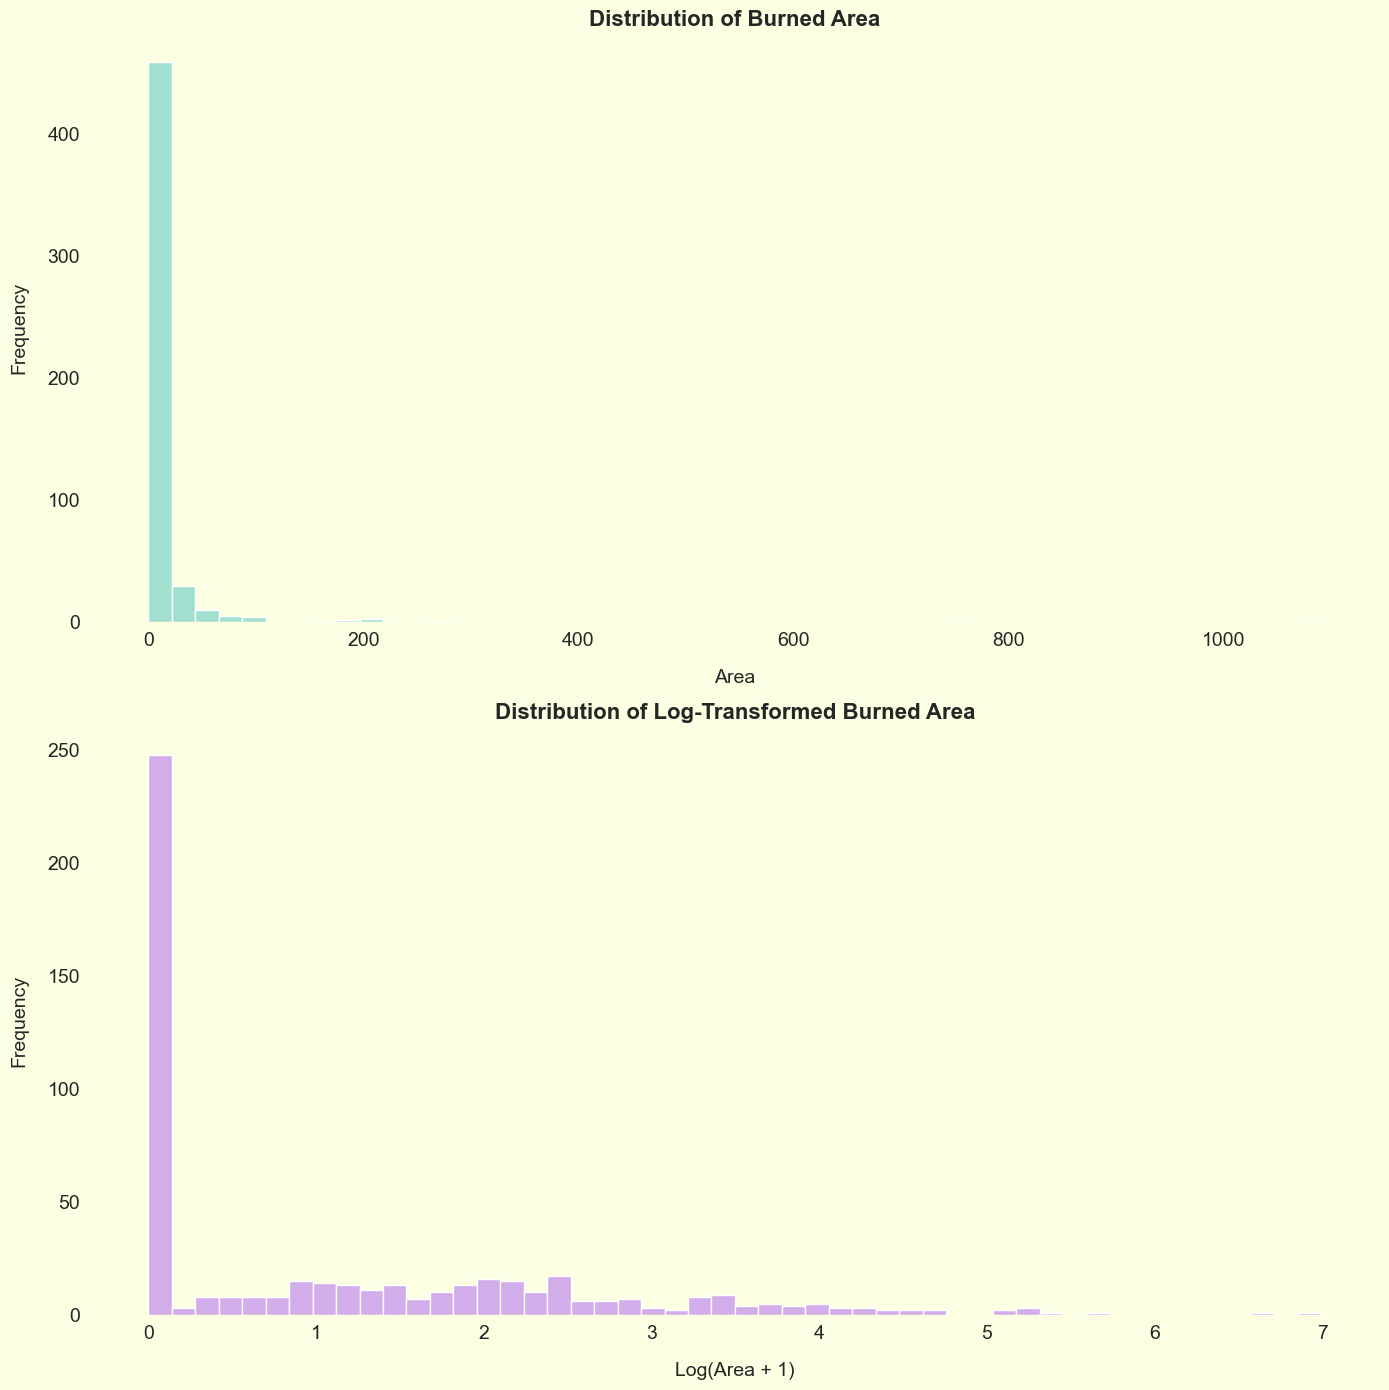

In [3]:
# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Histogram for raw 'area'
sns.histplot(fires_df['area'], bins=50, kde=False, color="#85d5c8", ax=axes[0])
axes[0].set_title("Distribution of Burned Area")
axes[0].set_xlabel("Area")
axes[0].set_ylabel("Frequency")

# Histogram for log-transformed 'area'
sns.histplot(fires_df['log_area'], bins=50, kde=False, color="#c392ec", ax=axes[1])
axes[1].set_title("Distribution of Log-Transformed Burned Area")
axes[1].set_xlabel("Log(Area + 1)")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

### Distribution Analysis of the Target Variable

---

I examined the distribution of the target variable `area` and its log-transformed version `log_area` using frequency bins and histograms.

**Original `area` distribution:**

- The distribution is extremely right-skewed.
- The majority of fires (≈95.7%) have very small burned areas within the first bin (0–54.5 hectares).
- Only a tiny fraction of observations fall in larger bins, with sporadic occurrences extending up to over 1,000 hectares.
- This highlights the presence of rare but extreme fire events in the dataset.

**Log-transformed `log_area` distribution:**

- The log transformation reduces skewness and spreads the values more evenly across bins.
- The first bin (≈0–0.35, corresponding roughly to area 0–0.42) still contains a large portion of fires (≈49%), but subsequent bins show a gradual and more interpretable decrease in frequency.
- The distribution after log transformation captures smaller, moderate, and larger fire events in a way that is easier to visualize and model.


## Categorical Distributions

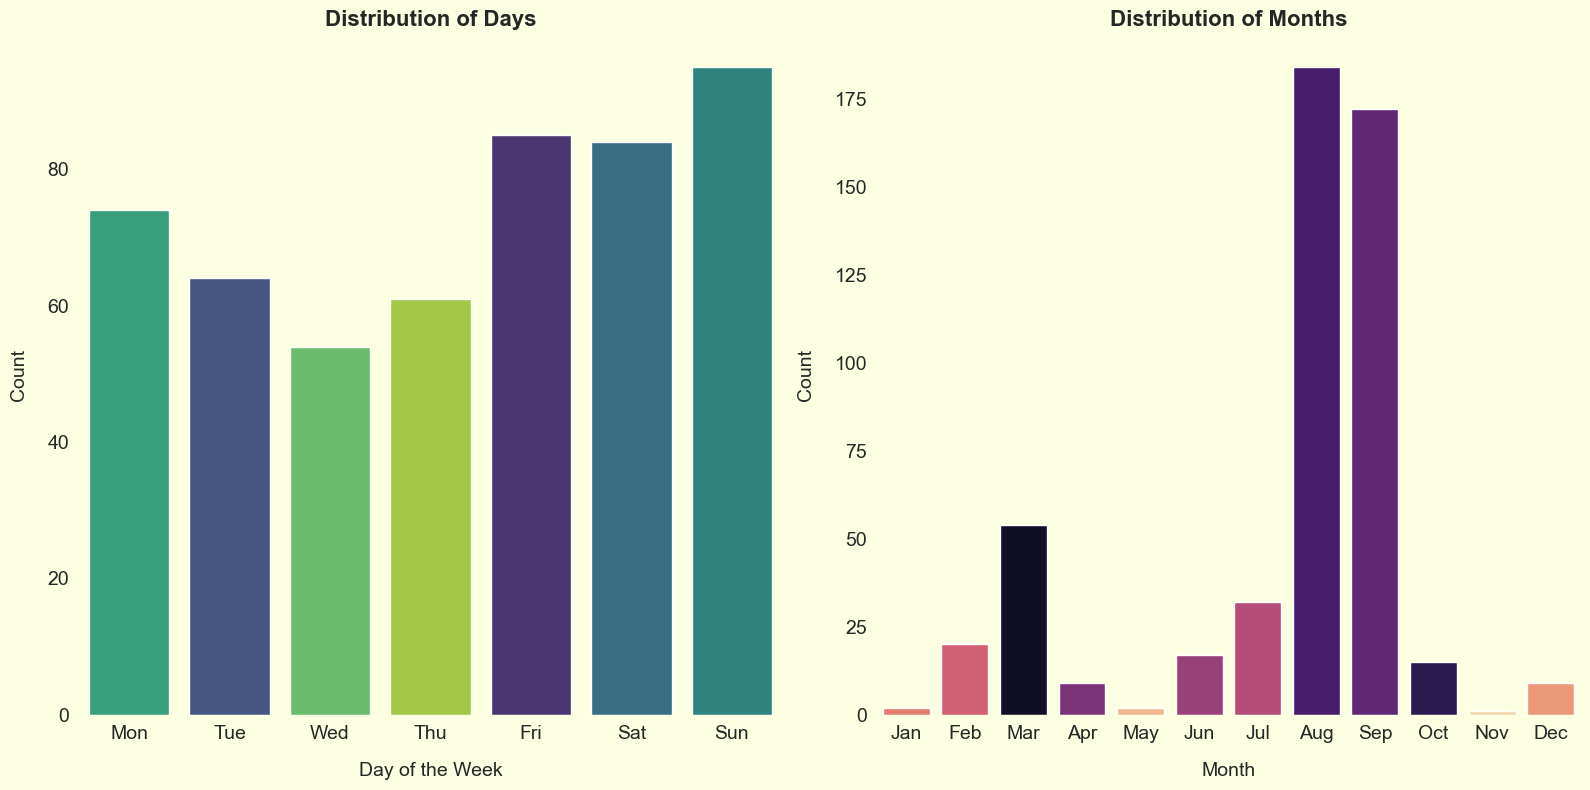

In [4]:
# List of categorical columns in the dataset
categorical_columns = ["month", "day"]

# Define the correct order for days and months (capitalized)
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Map lowercase values in the dataset to capitalized labels
fires_df["day"] = fires_df["day"].str.capitalize()
fires_df["month"] = fires_df["month"].str.capitalize()

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Barplot for 'day' in chronological order
sns.countplot(
    x="day", 
    data=fires_df, 
    ax=axes[0], 
    palette="viridis", 
    hue="day", 
    legend=False, 
    order=day_order
)
axes[0].set_title("Distribution of Days")
axes[0].set_xlabel("Day of the Week")
axes[0].set_ylabel("Count")

# Barplot for 'month' in chronological order
sns.countplot(
    x="month", 
    data=fires_df, 
    ax=axes[1], 
    palette="magma", 
    hue="month", 
    legend=False, 
    order=month_order
)
axes[1].set_title("Distribution of Months")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Categorical Columns: `day` and `month`

---

The dataset contains two categorical variables that describe the time dimension of the forest fire records: **day of the week** and **month of the year**.

#### Day of the Week
- The distribution of fire occurrences is **not fully uniform**.  
- The highest counts are on **Sunday (95)** and **Friday (85)**, followed closely by **Saturday (84)**.  
- The lowest counts are on **Wednesday (54)** and **Thursday (61)**.  
- While the differences are not extreme, there is a **slight concentration of fires toward weekends**, which may relate to weather patterns or human activity.

#### Month of the Year
- The monthly distribution shows a **strong seasonal pattern**.  
- Fires occur most frequently during **August (184)** and **September (172)**, followed by **March (54)** and **July (32)**.  
- Very few fires are recorded in **winter months**: **January (2)** and **December (9)**.  
- Spring months (**April: 9, May: 2**) and late autumn (**November: 1**) also show minimal activity.  
- This confirms that **summer and early autumn** are the peak fire seasons, strongly tied to climate conditions such as heat and dryness.


## Distribution of Log-Transformed Burned Area by Day and Month

In [5]:
# Summary statistics for Day vs Log(Areas)
day_summary = fires_df.groupby("day")["log_area"].describe()
day_summary = day_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
day_summary.rename(columns={"50%": "median"}, inplace=True)

# Summary statistics for Month vs Log(Areas)
month_summary = fires_df.groupby("month")["log_area"].describe()
month_summary = month_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
month_summary.rename(columns={"50%": "median"}, inplace=True)

print("Summary for 'day':")
display(day_summary)
print("\nSummary for 'month':")
display(month_summary)

Summary for 'day':


,count,mean,median,std,min,25%,75%,max
day,,,,,,,,
Fri,85.000,0.970,0.285,1.211,0.000,0.000,1.942,3.791
Mon,74.000,1.090,0.550,1.337,0.000,0.000,1.950,5.633
Sat,84.000,1.226,0.259,1.611,0.000,0.000,2.145,6.996
Sun,95.000,1.124,0.000,1.429,0.000,0.000,2.055,5.286
Thu,61.000,1.026,0.642,1.317,0.000,0.000,1.783,6.616
Tue,64.000,1.231,0.500,1.482,0.000,0.000,2.287,5.365
Wed,54.000,1.114,0.565,1.383,0.000,0.000,1.914,5.230



Summary for 'month':


,count,mean,median,std,min,25%,75%,max
month,,,,,,,,
Apr,9.000,1.089,0.000,1.486,0.000,0.000,1.725,4.129
Aug,184.000,1.045,0.435,1.361,0.000,0.000,1.796,6.616
Dec,9.000,2.572,2.462,0.449,1.853,2.329,2.937,3.249
Feb,20.000,1.088,0.371,1.292,0.000,0.000,2.014,3.966
Jan,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Jul,32.000,1.084,0.698,1.419,0.000,0.000,1.997,5.633
Jun,17.000,0.843,0.000,1.208,0.000,0.000,1.433,4.267
Mar,54.000,0.773,0.000,1.193,0.000,0.000,1.388,3.634
May,2.000,1.838,1.838,2.599,0.000,0.919,2.757,3.676


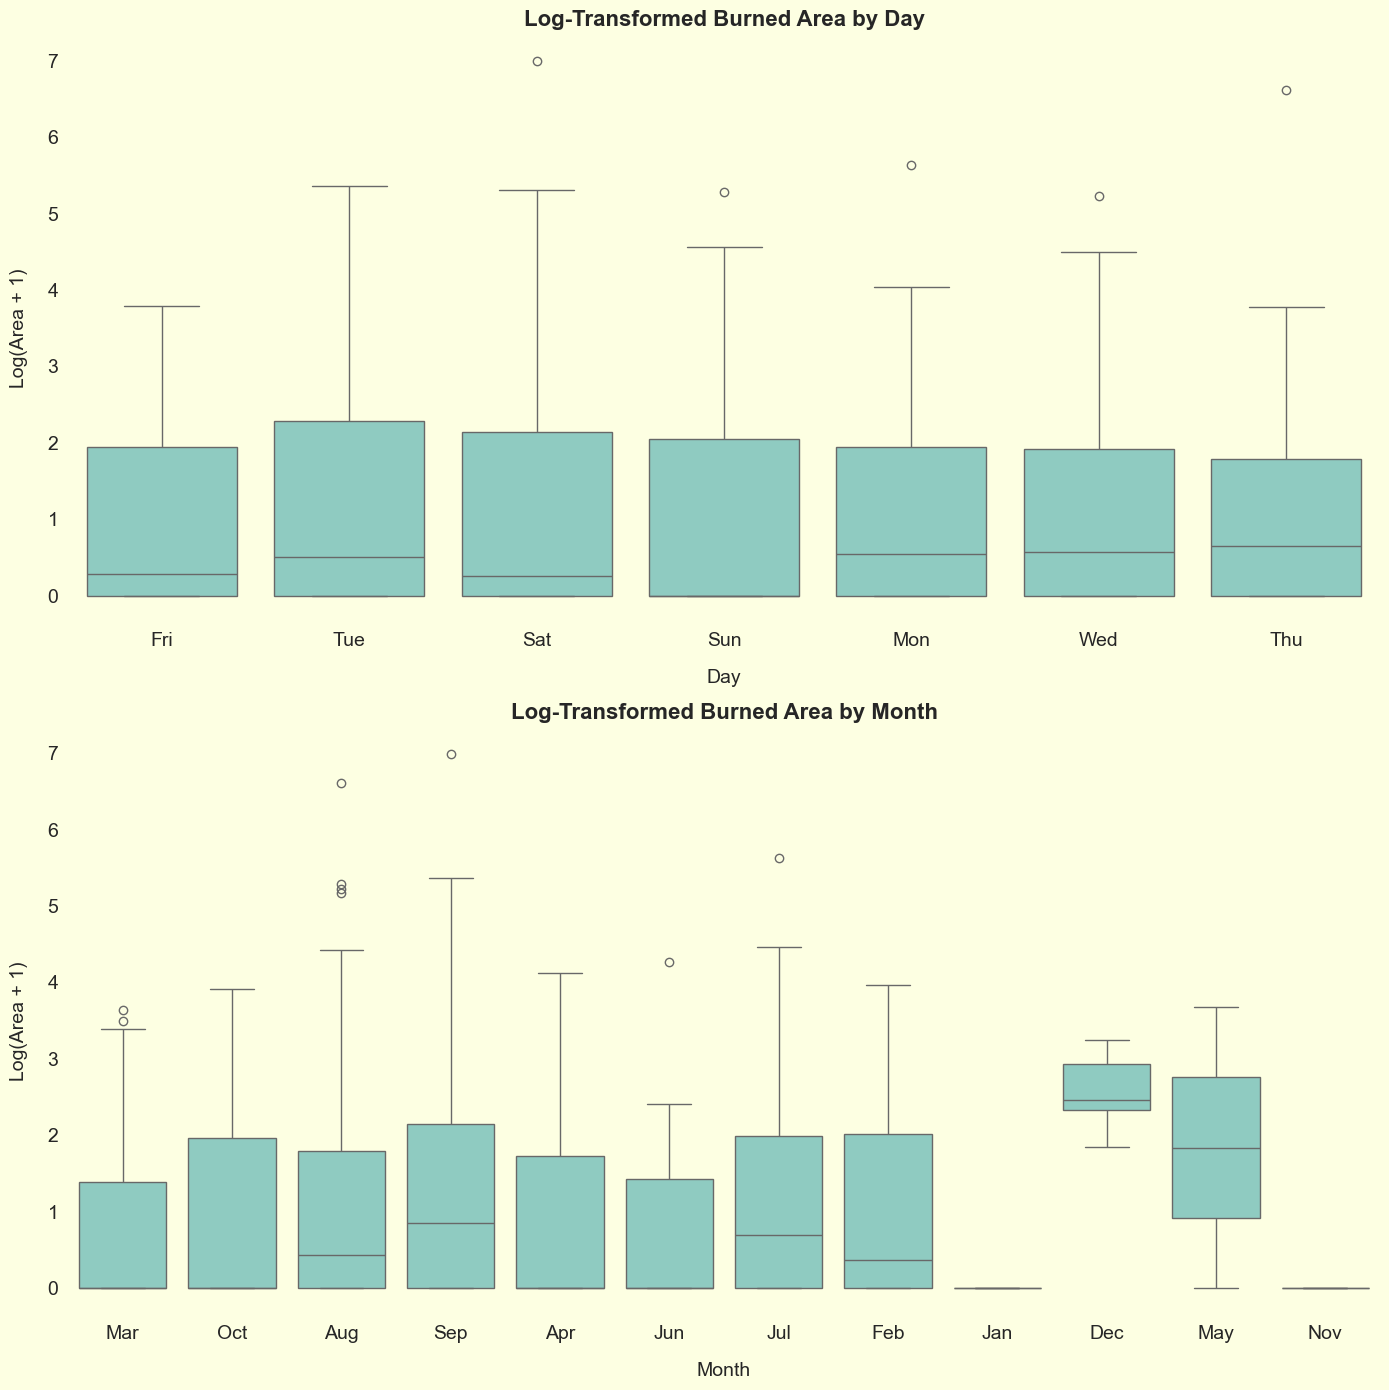

In [6]:
# Create a figure
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Boxplot: Day vs Log(Areas)
sns.boxplot(data=fires_df, x="day", y="log_area", ax=axes[0], color="#85d5c8")
axes[0].set_title("Log-Transformed Burned Area by Day")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Log(Area + 1)")

# Boxplot: Month vs Log(Areas)
sns.boxplot(data=fires_df, x="month", y="log_area", ax=axes[1], color="#85d5c8")
axes[1].set_title("Log-Transformed Burned Area by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Log(Area + 1)")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Log-Transformed Burned Area by Day and Month

---

#### Day of the Week
The summary statistics for `log_area` across different days of the week reveal some interesting patterns:

- **Median values** are low for most days, with Sunday having the lowest median (0.0), indicating that on many days no significant fire area is recorded.  
- **Mean values** are slightly higher than the medians, suggesting that some days experience a few extreme fire events. Tuesday (mean ≈ 1.23) and Saturday (mean ≈ 1.23) show the highest average log-transformed burned area.  
- **Variability** (std) is fairly consistent across days, ranging from ~1.21 to ~1.61. Saturday has the highest standard deviation, highlighting more inconsistent fire activity.  
- **Maximum values** indicate outliers on all days, with Saturday (≈6.996) and Monday (≈5.633) experiencing the largest single fire events.  

Overall, the distribution shows that fires are generally small on most days, but occasional extreme events skew the averages, particularly on weekends and early weekdays.

---

#### Month
The monthly summary provides insight into seasonal patterns:

- **High fire activity** is evident in August and September, with mean log_area values of 1.045 and 1.275, and median values well above 0, indicating more consistent fire events during late summer.  
- **Winter and early spring months** (Jan, Nov, Dec) show very low median burned areas, often 0, reflecting minimal fire occurrences. December is an exception with a small sample size but higher log_area (mean ≈ 2.57) due to a few extreme events.  
- **Variability** is largest in May and September, reflecting sporadic extreme fire events. May shows a particularly high standard deviation (~2.60) despite only two observations, indicating a single large fire significantly affecting the statistics.  
- **Outliers** are present in almost all months, particularly in summer and early fall, confirming that extreme fire events dominate the burned area distribution.  


## Numerical Distributions

In [7]:
# List of numerical columns in the dataset
numerical_columns = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# Create a dataframe with summary statistics
summary_df = fires_df[numerical_columns].describe().T

# Calculate IQR and outlier bounds
summary_df["IQR"] = summary_df["75%"] - summary_df["25%"]
summary_df["Lower Bound"] = summary_df["25%"] - 1.5 * summary_df["IQR"]
summary_df["Upper Bound"] = summary_df["75%"] + 1.5 * summary_df["IQR"]

# Display the summary statistics
display(summary_df)

,count,mean,std,min,25%,50%,75%,max,IQR,Lower Bound,Upper Bound
X,517.000,4.669,2.314,1.000,3.000,4.000,7.000,9.000,4.000,-3.000,13.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000,1.000,2.500,6.500
FFMC,469.000,90.580,5.698,18.700,90.200,91.600,92.800,96.200,2.600,86.300,96.700
DMC,496.000,111.195,64.008,1.100,70.800,108.300,141.575,291.300,70.775,-35.363,247.738
DC,474.000,550.673,246.061,7.900,441.200,664.500,713.900,860.600,272.700,32.150,1122.950
ISI,515.000,9.019,4.565,0.000,6.450,8.400,10.750,56.100,4.300,0.000,17.200
temp,496.000,18.885,5.748,2.200,15.475,19.300,22.725,33.300,7.250,4.600,33.600
RH,487.000,44.382,16.180,15.000,33.000,42.000,53.500,100.000,20.500,2.250,84.250
wind,482.000,4.022,1.794,0.400,2.700,4.000,4.900,9.400,2.200,-0.600,8.200
rain,485.000,0.023,0.306,0.000,0.000,0.000,0.000,6.400,0.000,0.000,0.000


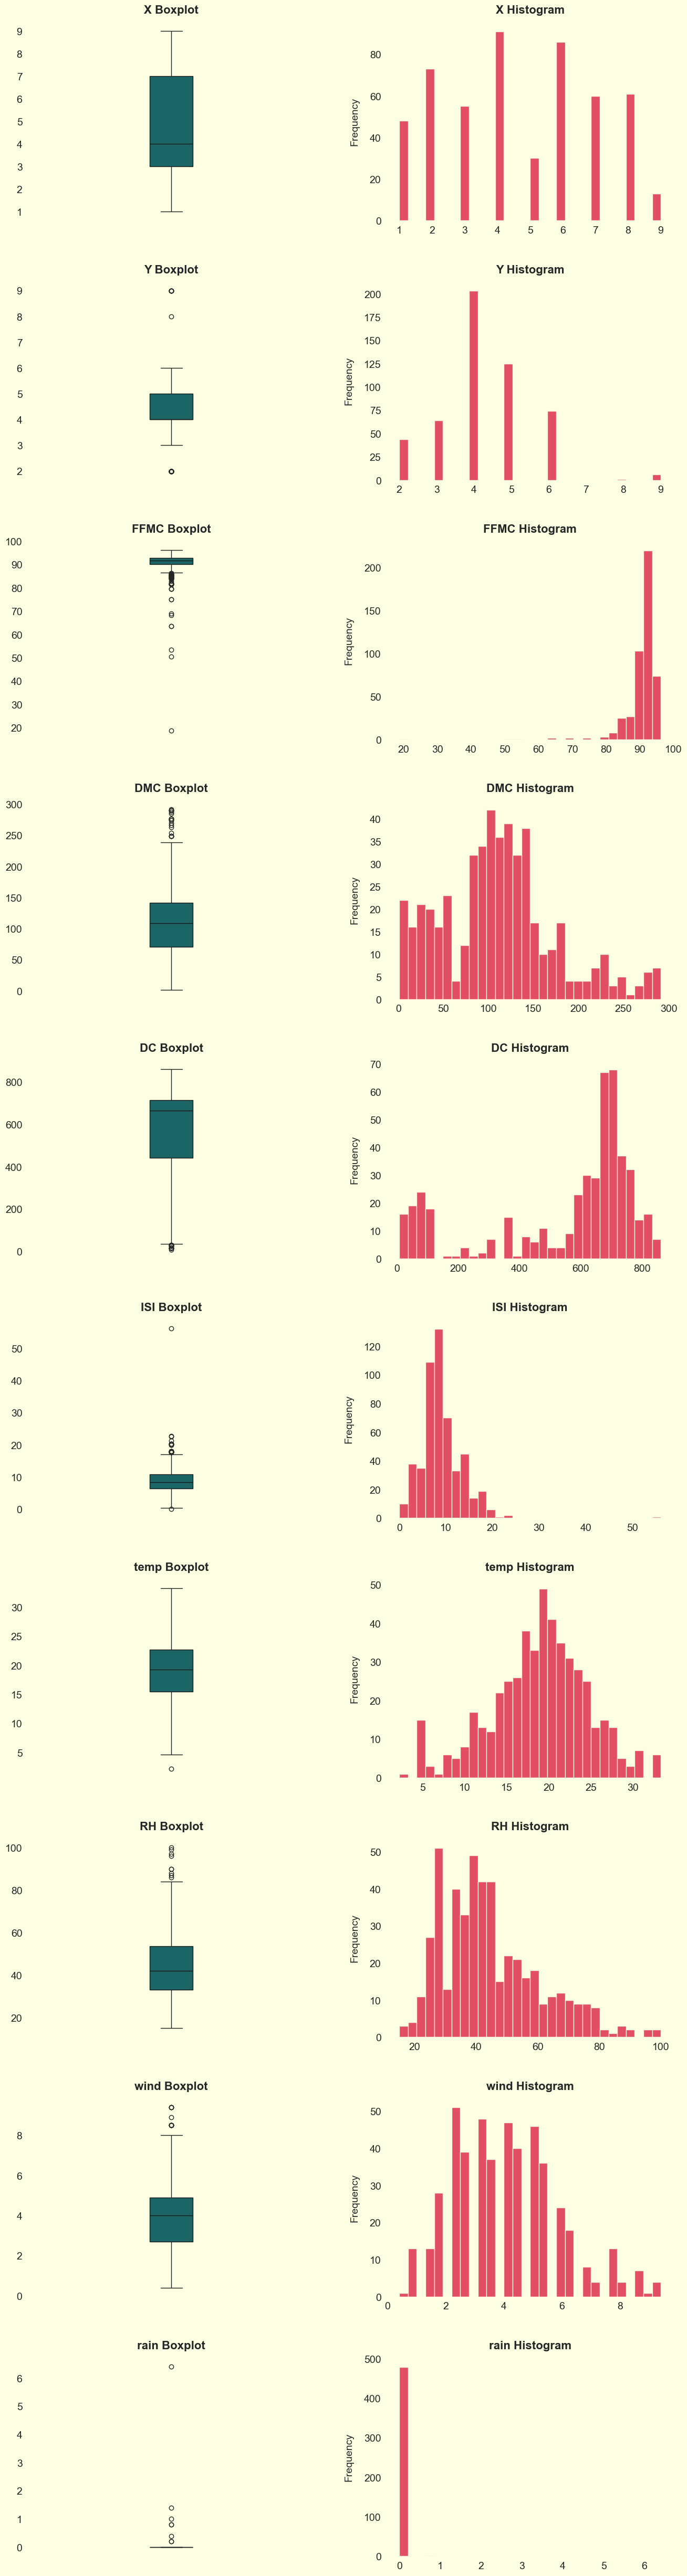

In [8]:
# Set up subplots: 10 variables → 10 rows × 2 columns (boxplot + histogram)
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(14, 50))

# Flatten axes for easy iteration
for i, col in enumerate(numerical_columns):
    
    # --- Boxplot ---
    sns.boxplot(
        data=fires_df, y=col, ax=axes[i, 0], color='#0F7173', width=.15,
        boxprops=dict(edgecolor="#1a1a1a"),
        medianprops=dict(color="#1a1a1a"),
        whiskerprops=dict(color="#1a1a1a"),
        capprops=dict(color="#1a1a1a")
    )
    axes[i, 0].set_title(f"{col} Boxplot", pad=12)
    axes[i, 0].set_ylabel("")
    axes[i, 0].set_xlabel("")

    # --- Histogram ---
    axes[i, 1].hist(fires_df[col], bins=30, color="#DF3B57", edgecolor="#FDFFE2", alpha=.9)
    axes[i, 1].set_title(f"{col} Histogram", pad=12)
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].set_xlabel("")

# Adjust layout
plt.tight_layout(pad=4)
plt.show()

### Analysis of Numerical Distributions

---

- **X and Y (spatial coordinates)**  
  Both X and Y are uniformly distributed integers within a limited range. They don’t show extreme skewness but have some concentration at certain points, likely reflecting the layout of the forest grid.

- **FFMC, DMC, DC, and ISI (fire weather indices)**  
  - **FFMC** values are tightly clustered at the high end, indicating that most days had dry conditions suitable for fire spread.  
  - **DMC** and **DC** have right-skewed distributions, with a few very high values. This suggests that while many days have moderate values, occasionally the conditions were extreme.  
  - **ISI** is also right-skewed, with most values near the lower end but occasional high spikes.

- **Temperature (temp)**  
  The distribution is roughly bell-shaped, centered around mild to warm values. Outliers exist at higher temperatures, which are important for fire risk.

- **Relative Humidity (RH)**  
  RH is left-skewed, with most observations concentrated at higher humidity levels. However, lower RH outliers (drier conditions) may be especially relevant for fire occurrence.

- **Wind**  
  Wind speeds are concentrated at the lower end, with very few extreme values. The distribution indicates most days had light winds, though rare higher values might strongly influence fire spread.

- **Rain**  
  Rainfall is highly skewed with the majority of observations being zero, reflecting many dry days. A small number of heavy rainfall events create long tails in the distribution.

---

**Key Observations**  
- Many meteorological variables (DMC, DC, ISI, Rain) are heavily skewed, highlighting that extreme conditions are rare but impactful.  
- Outliers, especially in **Rain** and **Fire Weather Indices**, may strongly affect modeling and should be considered carefully (e.g., log-transformations or robust models).  
- **Temperature** and **Relative Humidity** show more natural environmental variation, with clear patterns that align with expected weather distributions.


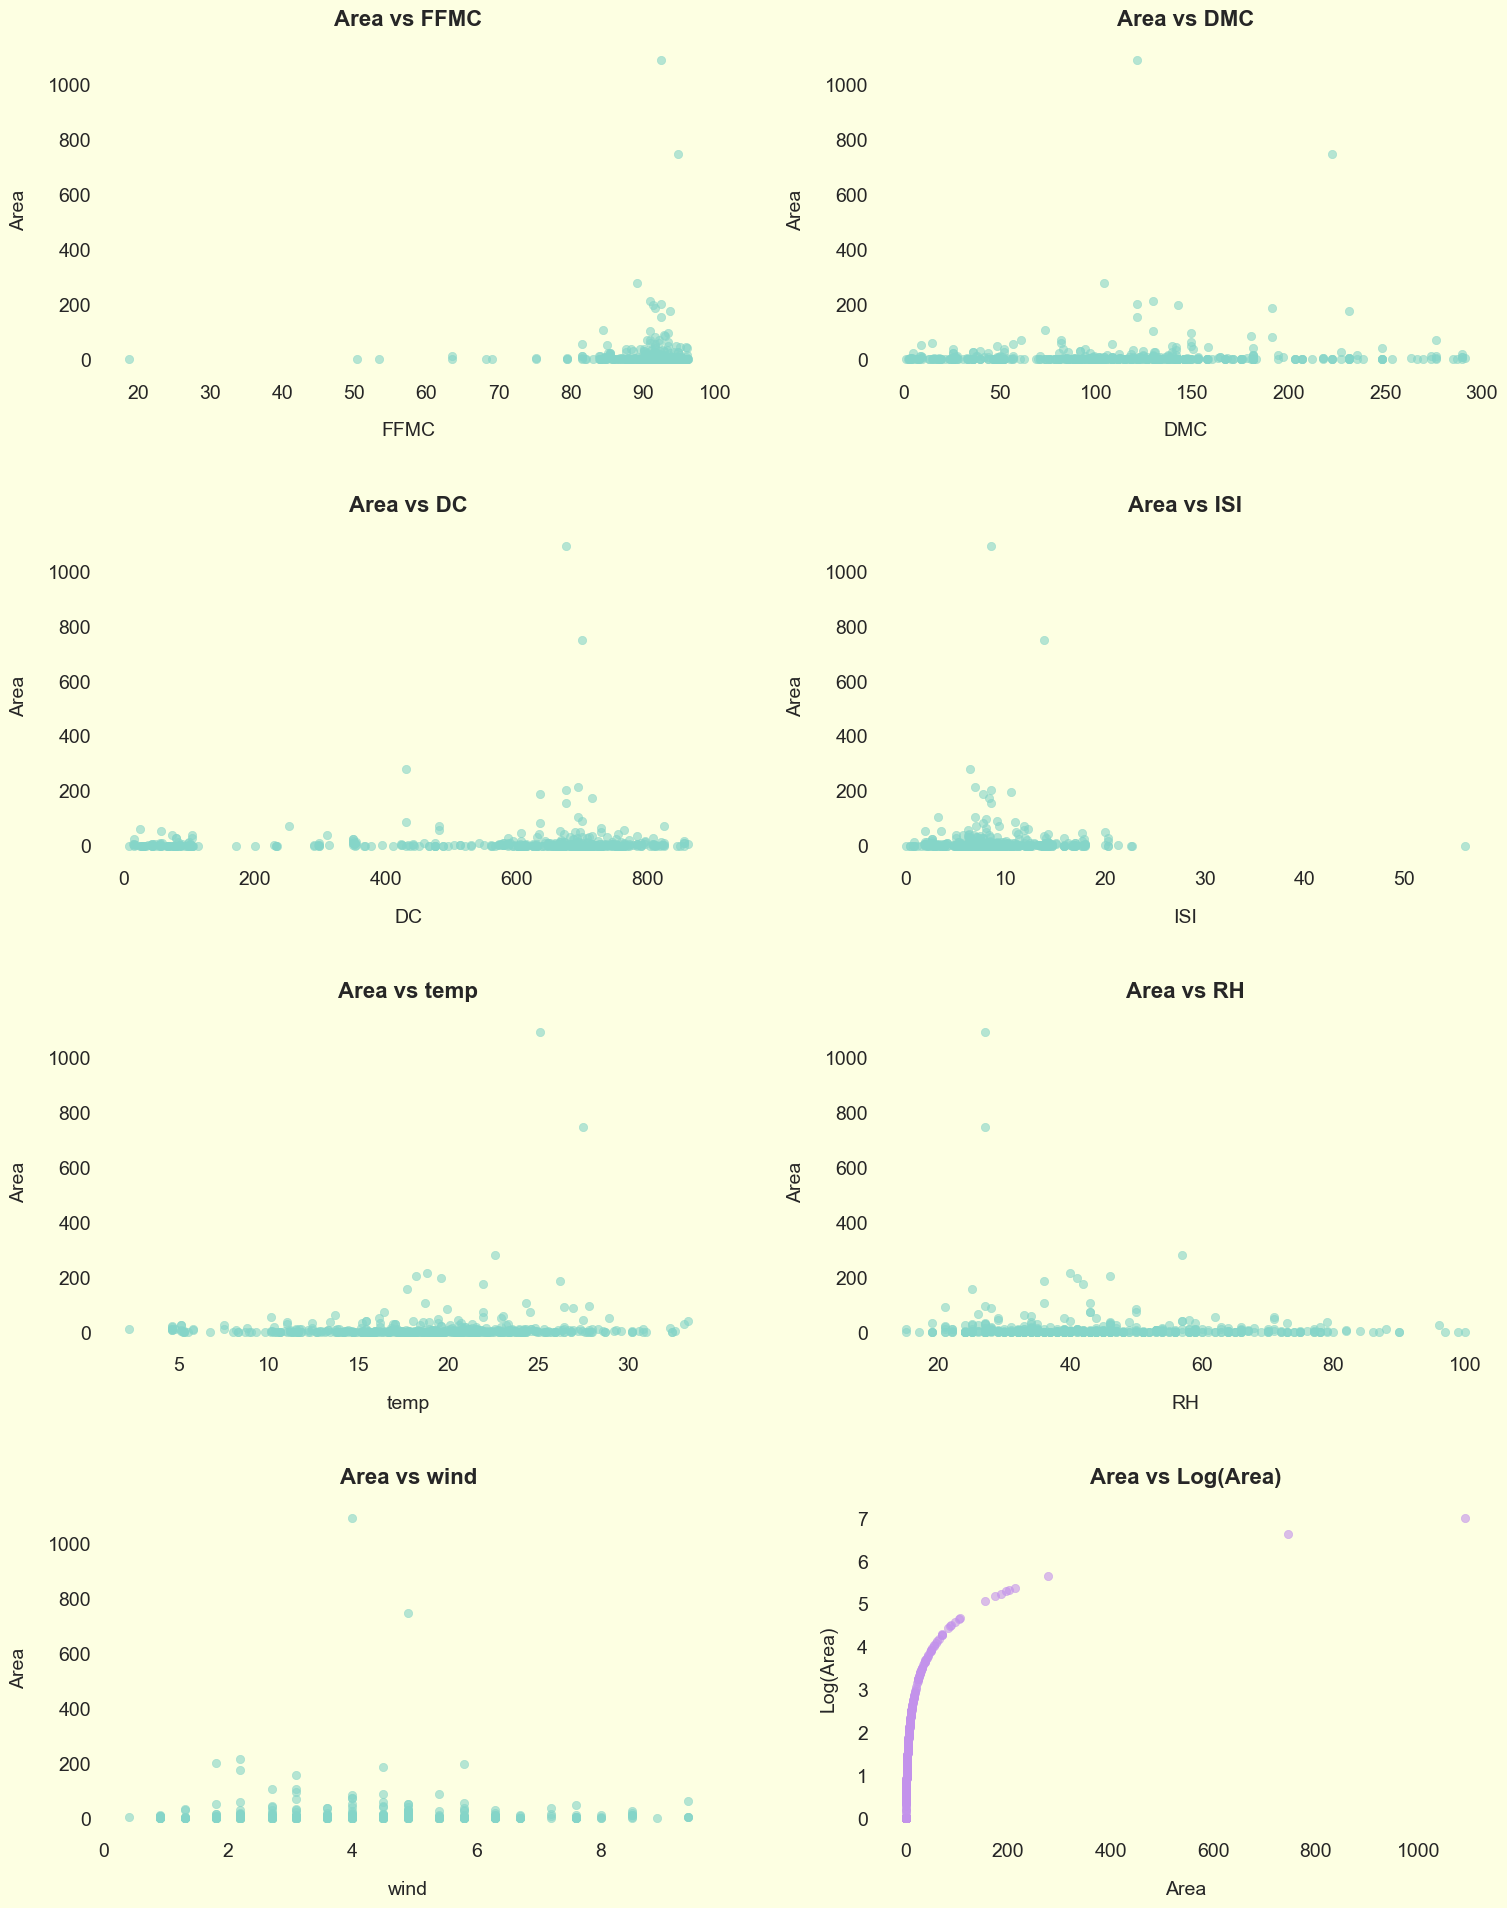

In [9]:
# Select predictors to explore
predictors = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind"]

# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

# Plot scatterplots for area
for i, col in enumerate(predictors):
    ax = axes[i]
    sns.scatterplot(
        data=fires_df, x=col, y="area", 
        ax=ax, alpha=0.6, edgecolor=None, color="#85d5c8"
    )
    ax.set_title(f"Area vs {col}", pad=14)
    ax.set_ylabel("Area")
    ax.set_xlabel(col)

# Last slot: area vs log_area for comparison
sns.scatterplot(
    data=fires_df, x="area", y="log_area", 
    ax=axes[-1], alpha=0.6, edgecolor=None, color="#c392ec"
)
axes[-1].set_title("Area vs Log(Area)", pad=14)
axes[-1].set_ylabel("Log(Area)")
axes[-1].set_xlabel("Area")

plt.tight_layout(pad=4)
plt.show()

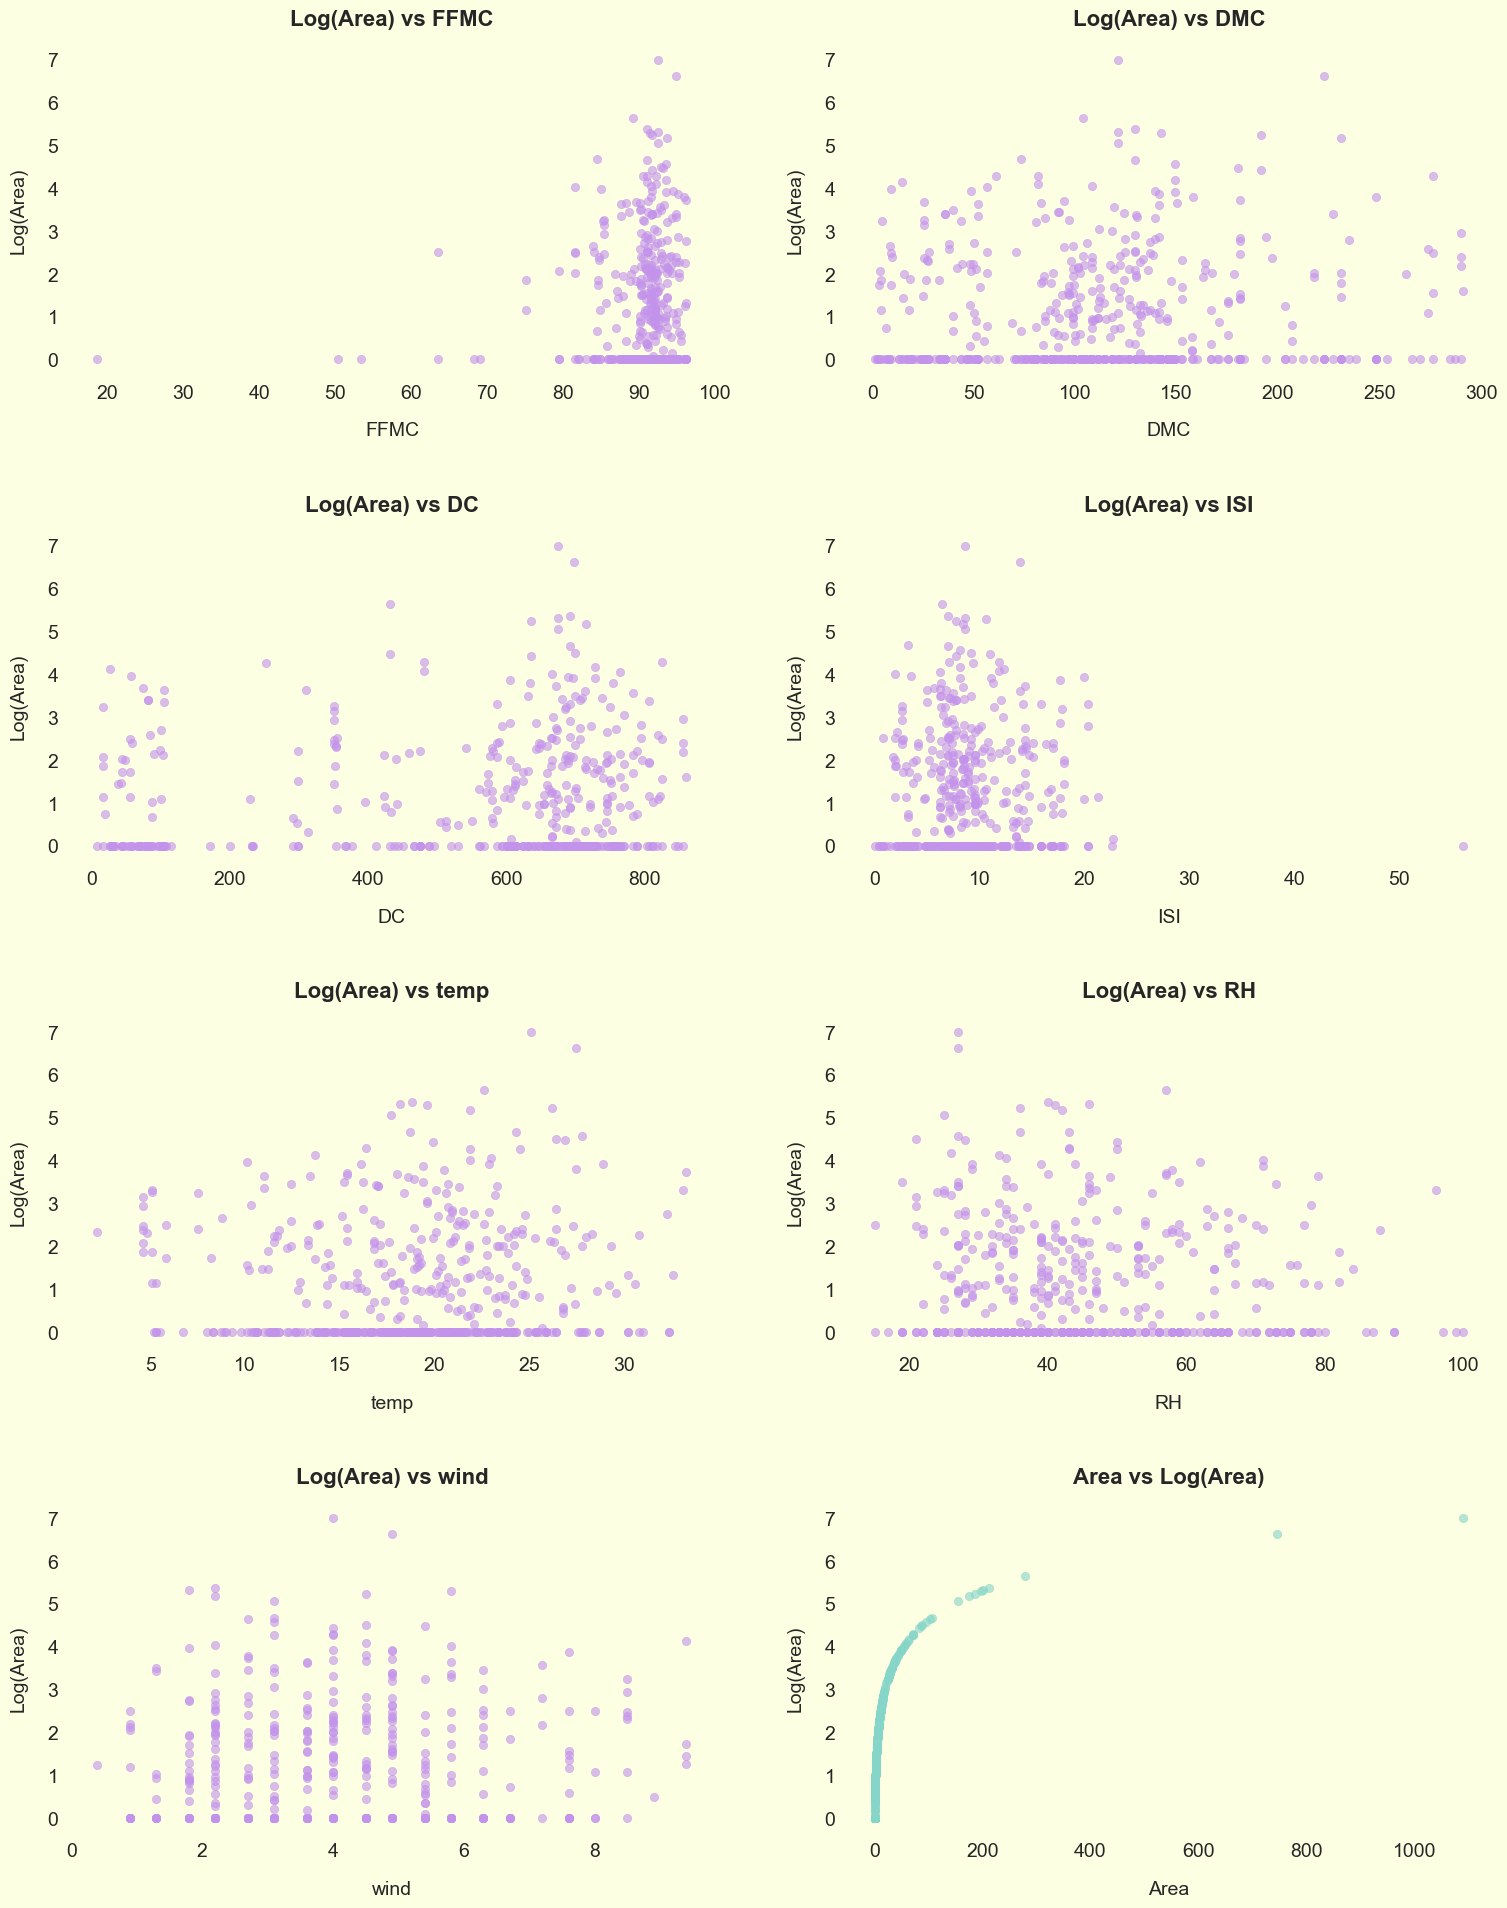

In [10]:
# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

# Plot scatterplots for log_area
for i, col in enumerate(predictors):
    ax = axes[i]
    sns.scatterplot(
        data=fires_df, x=col, y="log_area",
        ax=ax, alpha=0.6, edgecolor=None, color="#c392ec"
    )
    ax.set_title(f"Log(Area) vs {col}", pad=14)
    ax.set_ylabel("Log(Area)")
    ax.set_xlabel(col)

# Last slot: area vs log_area for comparison
sns.scatterplot(
    data=fires_df, x="area", y="log_area",
    ax=axes[-1], alpha=0.6, edgecolor=None, color="#85d5c8"
)
axes[-1].set_title("Area vs Log(Area)", pad=14)
axes[-1].set_ylabel("Log(Area)")
axes[-1].set_xlabel("Area")

plt.tight_layout(pad=4)
plt.show()

## Scatterplot Analysis: Area vs Log(Area)

---

### Raw `area` relationships
- **Heavy skewness:** Most data points cluster near zero across all predictors, making it difficult to see trends.
- **Outliers dominate:** A few extreme fire areas (hundreds of hectares) stretch the y-axis and obscure the main cloud of points.
- **Flat appearance:** Variables like FFMC, DMC, DC, ISI, temperature, RH, and wind show no obvious linear relation with raw `area`. This is expected due to the heavy-tailed distribution.

### `log_area` relationships
- **Improved spread:** Log transformation compresses extreme outliers and expands the lower range, revealing more structure.
- **FFMC, DMC, DC, ISI:** Weak upward trends are visible — higher fire weather indices tend to associate with larger `log_area`.
- **Temperature:** Slight positive relationship; warmer conditions might support larger fires.
- **Relative Humidity (RH):** Tendency toward a negative relationship — higher humidity is generally linked with smaller fires.
- **Wind:** Scatter shows more vertical spread, but no clear pattern; effect might be nonlinear or interact with other variables.

### Takeaways
- Raw `area` is too skewed for meaningful direct scatterplots.
- `log_area` provides a clearer view, showing weak but interpretable trends with weather indices, temperature, and humidity.
- These patterns suggest that modeling `log_area` instead of raw `area` will likely yield better predictive performance and interpretability.


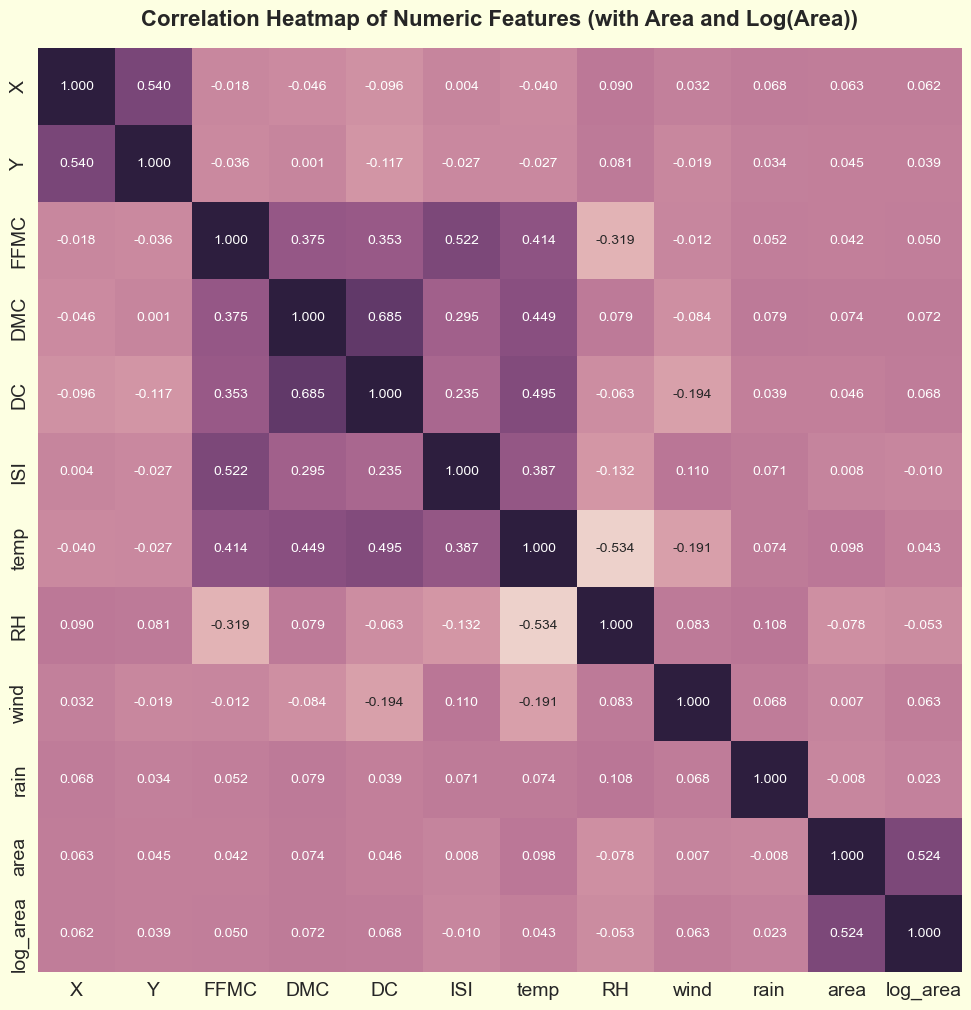

In [11]:
# Create correlation matrix including both 'area' and 'log_area'
corr_matrix = fires_df[['X','Y','FFMC','DMC','DC','ISI','temp','RH','wind','rain','area','log_area']].corr()

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, fmt=".3f", cmap=sns.cubehelix_palette(as_cmap=True), 
    cbar=False, square=True, linewidths=0
)
plt.title("Correlation Heatmap of Numeric Features (with Area and Log(Area))", pad=16)
plt.show()

### Correlation Analysis of Numeric Features (including `area` and `log_area`)

---

#### Target Variables: `area` vs `log_area`
- **Raw `area`:**
  - Shows only very weak correlations with predictors (highest: `temp` at **0.10**).
  - This confirms that the raw target is dominated by skewness and outliers, which masks potential relationships.

- **Log-transformed `area`:**
  - Correlations are slightly clearer but still weak (all ≤ **0.07** with predictors).
  - The strongest correlation remains with the raw `area` itself (**0.52**), as expected.
  - Even though correlations are low, scatterplots suggested that `log_area` provides a more interpretable spread, especially for `FFMC`, `DMC`, `DC`, `ISI`, and `RH`.

#### Key Takeaways
- Fire indices are highly interrelated, as expected from their shared system design.
- Temperature and relative humidity are strongly (and inversely) related, reflecting climate conditions that influence fires.
- Both `area` and `log_area` have weak linear correlations with predictors. However, the **log transformation reduces skewness**, making patterns more visible in scatterplots despite low correlation coefficients.
- Predictive models may need to capture **nonlinear relationships and interactions** (e.g., using tree-based models or regularized regressions) rather than relying on linear associations alone.


## Data Preprocessing

## Missing Values

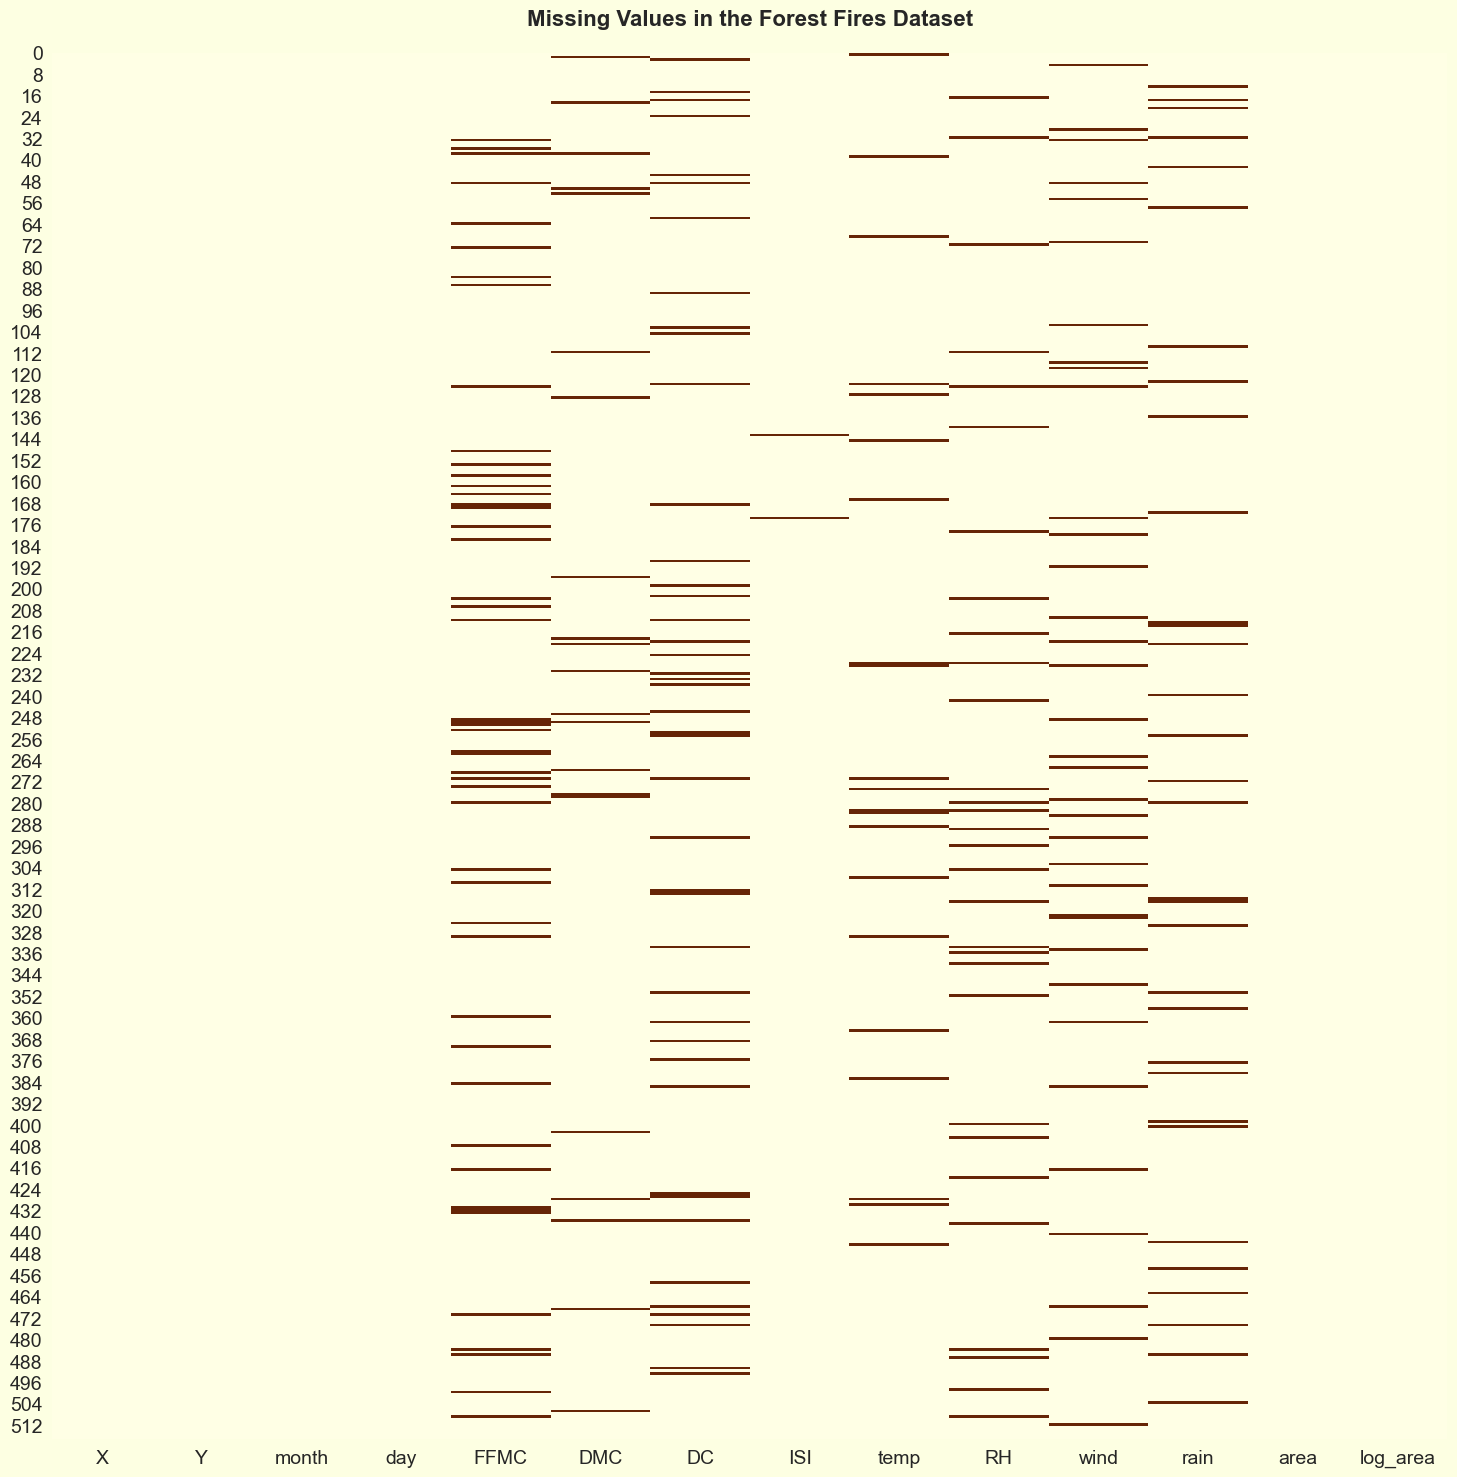

In [12]:
# Visualize missing values with a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(fires_df.isnull(), cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title("Missing Values in the Forest Fires Dataset", pad=20)
plt.show()

### Missing Values Exploration

---

I examined the dataset for **missing values**.  
I plotted a Seaborn heatmap of `isnull()` to scan for patterns. The missing cells are **sprinkled across rows and features** without clear blocks by time, location, or variable. In short, **no strong pattern**—the gaps look mostly random, which supports using an imputation method that leverages nearby samples.

---

### Imputation Plan: KNNImputer (numeric-only)

- I’ll impute **only numeric features** with **KNNImputer** so that estimates come from “similar” records.  
- Because KNN uses distances, I will **standardize numeric features before imputation** (so large-range variables like `DC` don’t dominate).  
- Categorical features (`month`, `day`) have no missing values and are left as-is.  
- The target `area` will not be imputed.


In [13]:
# Config
rng = np.random.default_rng(42)
mask_frac = 0.1        # fraction of observed numeric entries to hide in each trial
n_trials  = 5          # repeat masking to stabilize the estimate
param_grid = {         # search space for the imputer only
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}

# Score one (n_neighbors, weights) with mask-and-reconstruct RMSE ----
def score_imputer(X_num, n_neighbors, weights):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("impute", KNNImputer(n_neighbors=n_neighbors, weights=weights))
    ])
    rmses = []
    # trials
    for _ in range(n_trials):
        X = X_num.copy()
        
        # indices of observed cells
        observed = np.argwhere(~np.isnan(X))
        
        # pick cells to hide
        k = int(np.floor(mask_frac * len(observed)))
        take_idx = rng.choice(len(observed), size=k, replace=False)
        rows, cols = observed[take_idx].T
        
        # stash true values, then mask them
        true_vals = X[rows, cols].copy()
        X[rows, cols] = np.nan

        # fit on partially-masked data and reconstruct
        X_imp = pipe.fit_transform(X)
        preds = X_imp[rows, cols]

        # RMSE on masked cells
        rmse = np.sqrt(np.mean((preds - true_vals)**2))
        rmses.append(rmse)
        
    return float(np.mean(rmses))

# Grid search over imputer params (numeric-only)
X_num = fires_df[numerical_columns].to_numpy(dtype=float)
best = None
results = []

for n_neighbors, weights in product(param_grid["n_neighbors"], param_grid["weights"]):
    rmse = score_imputer(X_num, n_neighbors, weights)
    results.append({"n_neighbors": n_neighbors, "weights": weights, "rmse": rmse})
    if (best is None) or (rmse < best["rmse"]):
        best = {"n_neighbors": n_neighbors, "weights": weights, "rmse": rmse}

results_df = pd.DataFrame(results).sort_values("rmse")
print("Imputer CV (lower is better):")
display(results_df)

print(f"\nBest params -> n_neighbors={best['n_neighbors']}, weights='{best['weights']}', RMSE={best['rmse']:.4f}")

# Fit the final scaler+imputer on real data (with true NaNs) and transform
final_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("impute", KNNImputer(n_neighbors=best["n_neighbors"], weights=best["weights"]))
])

fires_df[numerical_columns] = final_pipe.fit_transform(fires_df[numerical_columns])

# Check the results
assert fires_df[numerical_columns].isna().sum().sum() == 0
print("Numeric NaNs after final impute:", fires_df[numerical_columns].isna().sum().sum())

Imputer CV (lower is better):


,n_neighbors,weights,rmse
5,7,distance,186.541
0,3,uniform,188.232
6,9,uniform,188.338
4,7,uniform,189.388
3,5,distance,191.441
1,3,distance,195.383
7,9,distance,198.055
9,11,distance,198.381
2,5,uniform,207.003
8,11,uniform,209.466



Best params -> n_neighbors=7, weights='distance', RMSE=186.5411
Numeric NaNs after final impute: 0


### Handling Missing Values with Optimized KNN Imputation  

---

After identifying the missing values in the dataset, I applied an optimized **K-Nearest Neighbors (KNN) imputation** approach. This method replaces each missing value with a weighted average of the values from its nearest neighbors, where neighbors are chosen based on feature similarity.  

#### Why KNN Imputation?  
- **Preserves feature relationships**: Unlike mean or median imputation, KNN leverages the correlations between variables, producing more realistic estimates.  
- **Suitable for continuous variables**: Most missing values were in numeric meteorological and fire index features, making KNN a good choice.  
- **Effective for small datasets**: With a relatively modest dataset size, exploiting neighbor similarity provides more informative imputations than global averages.  

#### Implementation Steps  
1. **Standardization**: All numeric features were standardized using `StandardScaler` so that large-range features (e.g., *DC*) did not dominate distance calculations.  
2. **Imputation Optimization**: A small cross-validation experiment was performed by masking observed values and measuring reconstruction error (RMSE).  
   - The best configuration was **7 neighbors** with **distance-based weighting**.  
   - This setup achieved the lowest RMSE (~186.5) in reconstructing masked values.  
3. **Final Transformation**: The fitted scaler–imputer pipeline was applied to the dataset, and the values were transformed back to their original scale for interpretability.  

#### Result  
All missing values were successfully imputed, leaving a **fully complete dataset (0 NaNs)**. This ensures the dataset is ready for further preprocessing, exploratory analysis, and eventual modeling without losing data or introducing unrealistic imputations.  


## Feature Engineering

In [14]:
# Encode the Day column -> is_weekend
# Sat & Sun = weekend (1), else weekday (0)
fires_df["is_weekend"] = fires_df["day"].isin(["Sat", "Sun"]).astype(int)

# Encode the Month column -> fire_season
# Define fire risk mapping
fire_season_map = {
    "Jan": "low", "Feb": "low", "Mar": "low", "Apr": "low",
    "May": "med", "Jun": "med",
    "Jul": "high", "Aug": "high", "Sep": "high",
    "Oct": "med",
    "Nov": "low", "Dec": "low"
}

fires_df["fire_season"] = fires_df["month"].map(fire_season_map)

# Drop the original 'day' and 'month' columns
fires_df = fires_df.drop(columns=["day", "month"])

# Check the results
fires_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,is_weekend,fire_season
0,1.008,0.570,-0.770,-1.329,-1.857,-0.859,-1.572,0.409,1.494,-0.076,0.000,0.000,0,low
1,1.008,-0.244,0.003,-0.279,0.482,-0.508,-0.154,-0.704,-1.741,-0.076,0.000,0.000,0,med
2,1.008,-0.244,0.003,-1.056,-0.545,-0.508,-0.746,-0.704,-1.518,-0.076,0.000,0.000,1,med
3,1.441,1.384,0.197,-1.218,-1.925,-0.004,-1.843,3.255,-0.012,0.580,0.000,0.000,0,low
4,1.441,1.384,-0.225,-0.937,-1.825,0.127,-1.303,3.379,0.527,-0.076,0.000,0.000,1,low


### Feature Engineering: Day and Month  

---

To make the dataset more informative and easier to use in modeling, I transformed the raw `day` and `month` columns into new, domain-relevant features:  

- **`is_weekend`**:  
  - Binary indicator where **1 = weekend (Saturday or Sunday)** and **0 = weekday**.  
  - Fires are often influenced by human activity, which tends to increase on weekends due to outdoor recreation, camping, and tourism.  
  - This transformation allows the model to capture potential differences in fire occurrence and severity between weekdays and weekends.  

- **`fire_season`**:  
  - Categorical variable grouping months into **low**, **medium**, and **high** fire risk periods:  
    - *Low risk*: Jan, Feb, Mar, Apr, Nov, Dec  
    - *Medium risk*: May, Jun, Oct  
    - *High risk*: Jul, Aug, Sep  
  - This grouping reflects the strong seasonality of forest fires, where late summer and early autumn months (Jul–Sep) historically show the highest fire activity.  

Finally, the original `day` and `month` columns were dropped since they are now represented by these new engineered features. This reduces redundancy and ensures the model focuses on the more meaningful representations.  


In [15]:
# Safety: tiny negative values from prior steps (if any) → 0 for log1p
# KNN + inverse scaling can introduce tiny negatives near 0
for col in ["rain", "DMC", "DC", "ISI", "wind", "temp", "RH"]:
    if col in fires_df.columns:
        fires_df[col] = np.clip(fires_df[col], a_min=0, a_max=None)

# Rain: presence + magnitude (log) 
fires_df["rain_present"] = (fires_df["rain"] > 0).astype(np.int8)
fires_df["rain_amount_log"] = np.where(fires_df["rain"] > 0, np.log1p(fires_df["rain"]), 0.0)

# Skewed indices: log1p versions (keep originals too)
fires_df["DMC_log"] = np.log1p(fires_df["DMC"])
fires_df["DC_log"]  = np.log1p(fires_df["DC"])
fires_df["ISI_log"] = np.log1p(fires_df["ISI"])

# Interactions capturing spread/dryness effects
fires_df["wind_x_ISI"] = fires_df["wind"] * fires_df["ISI"]
fires_df["temp_x_RH"]  = fires_df["temp"] * fires_df["RH"]

fires_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,log_area,is_weekend,fire_season,rain_present,rain_amount_log,DMC_log,DC_log,ISI_log,wind_x_ISI,temp_x_RH
0,1.008,0.570,-0.770,0.000,0.000,0.000,0.000,0.409,1.494,0.000,...,0.000,0,low,0,0.000,0.000,0.000,0.000,0.000,0.000
1,1.008,-0.244,0.003,0.000,0.482,0.000,0.000,0.000,0.000,0.000,...,0.000,0,med,0,0.000,0.000,0.393,0.000,0.000,0.000
2,1.008,-0.244,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1,med,0,0.000,0.000,0.000,0.000,0.000,0.000
3,1.441,1.384,0.197,0.000,0.000,0.000,0.000,3.255,0.000,0.580,...,0.000,0,low,1,0.457,0.000,0.000,0.000,0.000,0.000
4,1.441,1.384,-0.225,0.000,0.000,0.127,0.000,3.379,0.527,0.000,...,0.000,1,low,0,0.000,0.000,0.000,0.120,0.067,0.000


### Feature Engineering: Handling Skewness, Zero-Inflation, and Interactions  

---

Several new features were engineered to address the skewed distributions and zero-inflation in the dataset, while also capturing potential interactions that may better explain fire damage.  

#### 1. Safety Adjustment  
- Small negative values (artifacts from scaling and imputation) were clipped to zero.  
- This ensures that applying log-transformations does not introduce invalid results.  

#### 2. Rain Features  
- **`rain_present`**: Binary indicator (1 if rain > 0, else 0).  
- **`rain_amount_log`**: Log-transformed rain values (applied only where rain > 0, else 0).  
- Motivation: Most rows have no rain, so splitting into presence vs. magnitude allows the model to learn both *whether* it rained and *how much*.  

#### 3. Log-Transformed Fire Indices  
- **`DMC_log`**, **`DC_log`**, **`ISI_log`**: Log1p transformations of highly skewed fire indices.  
- Motivation: Reduces skewness and stabilizes variance, improving compatibility with linear models.  

#### 4. Interaction Features  
- **`wind_x_ISI`**: Product of wind speed and ISI, reflecting conditions that drive extreme fire spread.  
- **`temp_x_RH`**: Product of temperature and relative humidity, capturing the combined dryness effect.  


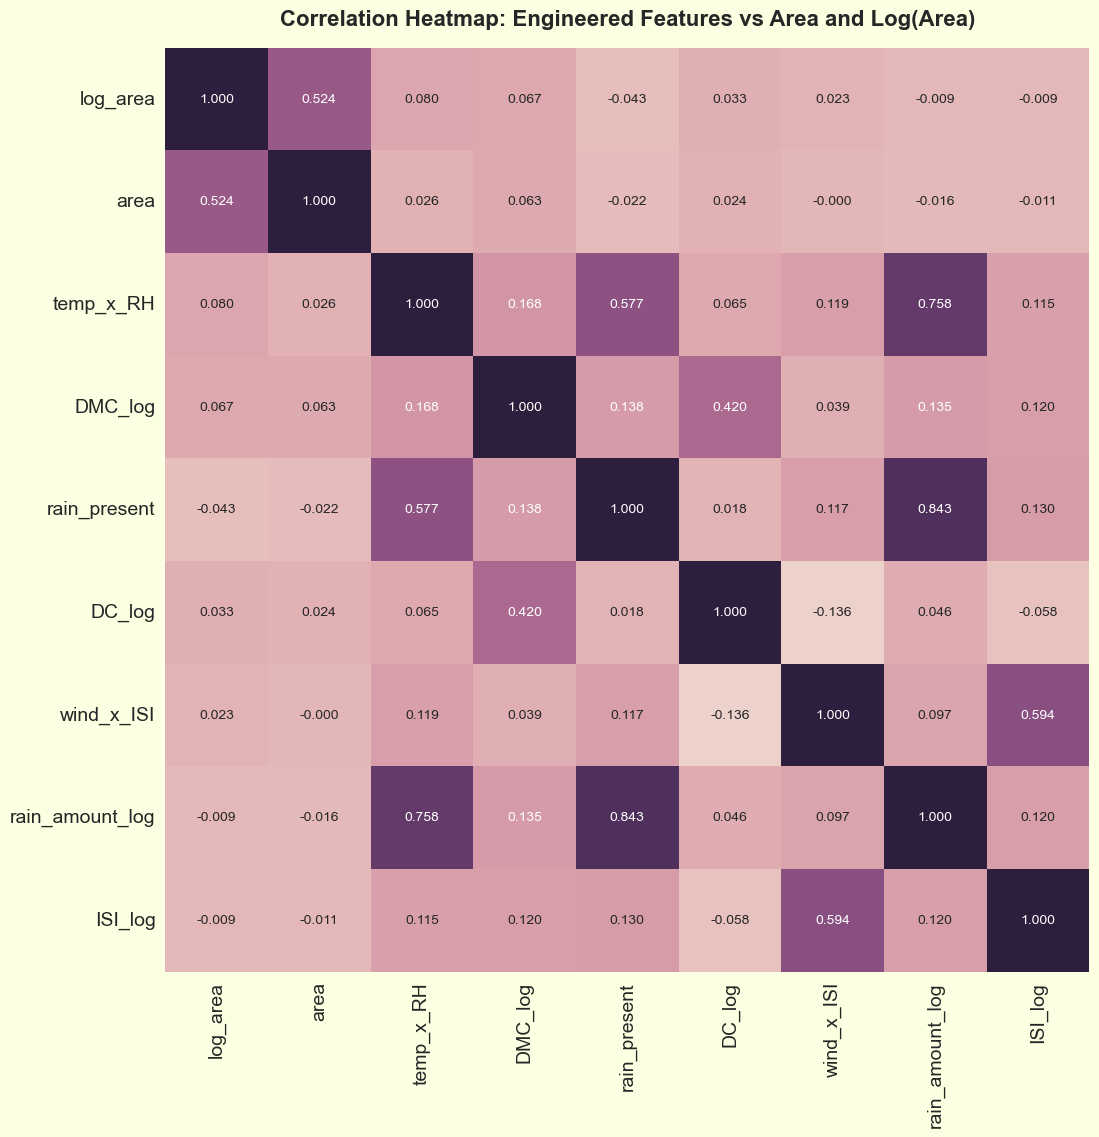

In [16]:
# Select engineered features + targets
engineered_cols = [
    "rain_present", "rain_amount_log",
    "DMC_log", "DC_log", "ISI_log",
    "wind_x_ISI", "temp_x_RH",
    "area", "log_area"
]

corr_df = fires_df[engineered_cols].corr()

# Sort rows/cols by correlation with log_area 
sorted_cols = corr_df["log_area"].abs().sort_values(ascending=False).index
corr_sorted = corr_df.loc[sorted_cols, sorted_cols]

# Plot the correlation heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_sorted,
    annot=True, fmt=".3f", cmap=sns.cubehelix_palette(as_cmap=True),
    cbar=False, square=True, linewidths=0
)
plt.title("Correlation Heatmap: Engineered Features vs Area and Log(Area)", pad=16)
plt.show()

### Correlation Analysis of Engineered Features  

---

To evaluate the usefulness of the newly engineered features, I computed a correlation heatmap including only:  

- **Engineered predictors**: `rain_present`, `rain_amount_log`, `DMC_log`, `DC_log`, `ISI_log`, `wind_x_ISI`, `temp_x_RH`  
- **Targets**: `area`, `log_area`  

The features were sorted by their absolute correlation with `log_area` to highlight the strongest relationships with the transformed target.  

---

#### Key Observations  

- **Log vs. Raw Target**  
  - As expected, `log_area` and `area` remain strongly correlated (**0.524**), confirming that the log-transformation preserves information while stabilizing skewness.  

- **Best Predictors of `log_area`**  
  - **`temp_x_RH` (0.080)**: The interaction between temperature and humidity shows the strongest direct link with `log_area`, suggesting that dryness conditions may modestly influence burned area size.  
  - **`DMC_log` (0.067)**: The Duff Moisture Code (log-transformed) also shows some positive correlation, meaning deeper fuel moisture plays a role in fire extent.  
  - **`rain_present` (-0.043)**: Weak negative correlation, but in the expected direction (fires spread less when rain is present).  

- **Weaker Predictors**  
  - `DC_log` (0.033), `wind_x_ISI` (0.023), and `rain_amount_log` (-0.009) all have very low correlations with `log_area`.  
  - `ISI_log` is essentially uncorrelated (-0.009), which may reflect that extreme ISI values are rare in this dataset.  

- **Feature Interdependencies**  
  - Strong correlations exist among some engineered features themselves:  
    - `rain_present` ↔ `rain_amount_log` (**0.843**), as expected since one is the binary presence and the other is the magnitude.  
    - `rain_amount_log` ↔ `temp_x_RH` (**0.758**): wetter conditions tend to coincide with higher humidity × temperature effects.  
    - `wind_x_ISI` ↔ `ISI_log` (**0.594**): consistent since ISI already incorporates wind.  

---

#### Takeaway  

- No single engineered feature has a strong direct linear correlation with the target (`log_area`), which aligns with the known difficulty of this dataset.  
- However, some signals emerge: **dryness indicators (`temp_x_RH`, `DMC_log`) and rain effects** are modestly informative.  
- The weak linear correlations reinforce the need to test **nonlinear models** (e.g., Random Forests, Gradient Boosting, SVR) that can capture complex interactions and thresholds that correlation alone cannot reveal.  


In [17]:
# One-hot encode fire_season 
fires_df = pd.get_dummies(fires_df, columns=["fire_season"], drop_first=True)

# fire_season categories become:
# fire_season_low, fire_season_med, fire_season_high
# With drop_first=True → only fire_season_low and fire_season_med remain

# Define feature groups
categorical_cols = ["is_weekend", "fire_season_low", "fire_season_med"]

numeric_cols = [
    "X", "Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain",
    # engineered features
    "rain_present", "rain_amount_log",
    "DMC_log", "DC_log", "ISI_log",
    "wind_x_ISI", "temp_x_RH"
]

target = "log_area"   # primary modeling target
target_raw = "area"   # keep for reference / inverse-transform

# Final feature set for modeling
final_features = categorical_cols + numeric_cols

### Encoding `fire_season` and Defining Final Feature Lists  

---

To finalize the dataset for modeling, I performed the following preprocessing steps:  

1. **Encoding `fire_season`**  
   - The categorical variable `fire_season` (low, med, high) was one-hot encoded.  
   - With `drop_first=True`, only two dummy variables remain:  
     - `fire_season_low`  
     - `fire_season_med`  
   - This avoids multicollinearity by using **low risk** as the baseline reference category.  

2. **Defining Feature Groups**  
   - **Categorical features**:  
     - `is_weekend` → binary indicator (0 = weekday, 1 = weekend).  
     - `fire_season_low`, `fire_season_med` → dummy variables from encoding.  
   - **Numeric features**:  
     - Original meteorological & spatial features: `X`, `Y`, `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`.  
     - Engineered features:  
       - `rain_present`, `rain_amount_log` (rain decomposition).  
       - `DMC_log`, `DC_log`, `ISI_log` (log-transformed fire indices).  
       - `wind_x_ISI`, `temp_x_RH` (interaction features).  
   - **Target variables**:  
     - `log_area` → primary target (stabilized, interpretable distribution).  
     - `area` → raw target (kept for reference and inverse-transform checks).  


## Building a Baseline Linear Regression Model

In [18]:
# Define X and y
X = fires_df[final_features]
y = fires_df[target]   # use log_area as target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None  # regression target → no stratification
)

# --- columns to scale (continuous only) ---
continuous_cols = [
    "X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain",
    "rain_amount_log","DMC_log","DC_log","ISI_log","wind_x_ISI","temp_x_RH"
]

# --- columns to pass through (no scaling): binaries/dummies ---
passthrough_cols = [c for c in X_train.columns if c not in continuous_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
        ("keep", "passthrough", passthrough_cols),
    ],
    remainder="drop"
)

# --- Baseline: Linear Regression on log_area ---
lin_pipe = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])

# --- CV on train (log-scale RMSE) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_log = -cross_val_score(
    lin_pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)

print(f"[Baseline Linear] CV RMSE (log): {cv_rmse_log.mean():.3f} ± {cv_rmse_log.std():.3f}")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Fit & predict ---
lin_pipe.fit(X_train, y_train)
y_pred_log_test = lin_pipe.predict(X_test)

# log-scale metrics
rmse_log = rmse(y_test, y_pred_log_test)
mae_log  = mean_absolute_error(y_test, y_pred_log_test)
r2_log   = r2_score(y_test, y_pred_log_test)

# Оriginal scale metrics (inverse transform)
y_test_raw = np.expm1(y_test)
y_pred_raw = np.expm1(y_pred_log_test)
rmse_raw = rmse(y_test_raw, y_pred_raw)
mae_raw  = mean_absolute_error(y_test_raw, y_pred_raw)
r2_raw   = r2_score(y_test_raw, y_pred_raw)

print(f"[Baseline Linear] Test RMSE (log): {rmse_log:.3f} | MAE (log): {mae_log:.3f} | R2 (log): {r2_log:.3f}")
print(f"[Baseline Linear] Test RMSE (raw): {rmse_raw:.2f} | MAE (raw): {mae_raw:.2f} | R2 (raw): {r2_raw:.3f}")

[Baseline Linear] CV RMSE (log): 1.426 ± 0.060
[Baseline Linear] Test RMSE (log): 1.543 | MAE (log): 1.259 | R2 (log): -0.084
[Baseline Linear] Test RMSE (raw): 109.93 | MAE (raw): 20.14 | R2 (raw): -0.025


### Baseline Model: Linear Regression  

---

To establish a reference point, I trained a **Linear Regression model** using the log-transformed target variable (`log_area`). The model included all preprocessed numeric, categorical, and engineered features. Continuous variables were standardized, while binary/dummy variables were passed through unchanged.  

---

#### Cross-Validation Performance (Training Set)
- **CV RMSE (log): 1.426 ± 0.060**  
  The average root mean squared error on the log scale indicates how well the model generalizes during training. The relatively low standard deviation suggests stable performance across folds, but the error is still fairly high.  

---

#### Test Set Performance
- **Log Scale**  
  - RMSE: **1.543**  
  - MAE: **1.259**  
  - R²: **-0.084**  
  The R² being negative means the model performs **worse than simply predicting the mean of the training target**. This shows the linear regression model fails to capture meaningful variance in the log-transformed target.  

- **Original Scale (back-transformed)**  
  - RMSE: **109.93**  
  - MAE: **20.14**  
  - R²: **-0.025**  
  The large RMSE (≈110 ha) highlights the difficulty of predicting burned area in absolute terms, especially given the heavy skew and large outliers in the dataset. The small negative R² again confirms that the linear model cannot explain the variance better than a constant mean predictor.  

---

#### Interpretation
- The **linear regression baseline performs poorly**, confirming what has been observed using this dataset:  
  - The predictors (`FFMC`, `DMC`, `DC`, weather, etc.) have **low direct correlation** with the target.  
  - The distribution of `area` is highly skewed, making linear methods struggle even after log transformation.  
- This baseline is still important because it provides a **benchmark**. Any future model (regularized linear models, polynomial/spline expansions, decision trees, random forests, gradient boosting, etc.) must improve upon these metrics to be considered useful.  


In [19]:
# Get correlations of all features vs. area and log_area
corr_targets = fires_df.corr()[["area", "log_area"]].sort_values(
    by="log_area", key=lambda x: x.abs(), ascending=False
)

# Display nicely
pd.set_option("display.float_format", "{:.3f}".format)
display(corr_targets)

,area,log_area
log_area,0.524,1.000
area,1.000,0.524
temp,0.106,0.096
temp_x_RH,0.026,0.080
DMC_log,0.063,0.067
X,0.063,0.062
DMC,0.056,0.059
FFMC,0.040,0.044
wind,-0.026,0.043
rain_present,-0.022,-0.043


## Feature Selection

In [20]:
# Quick filter by correlation threshold
corr_cutoff = 0.02
low_corr_feats = corr_targets[abs(corr_targets["log_area"]) < corr_cutoff].index.tolist()
X_train_fs = X_train.drop(columns=low_corr_feats)
X_test_fs  = X_test.drop(columns=low_corr_feats)

print(f"Removed low-correlation features: {low_corr_feats}")
print("Remaining features:", X_train_fs.shape[1])

# Recursive Feature Elimination with Cross-Validation
ridge_estimator = Ridge(alpha=1.0, random_state=42)

rfecv = RFECV(
    estimator=ridge_estimator,
    step=1,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rfecv.fit(X_train_fs, y_train)

selected_features = X_train_fs.columns[rfecv.support_].tolist()
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", selected_features)

# Keep only selected features
X_train_selected = X_train_fs[selected_features]
X_test_selected  = X_test_fs[selected_features]

Removed low-correlation features: ['ISI', 'rain_amount_log', 'ISI_log']
Remaining features: 17
Optimal number of features: 1
Selected features: ['temp_x_RH']


### Feature Selection Results

---

I applied feature selection in two stages:  
1. **Filter by correlation**: Features with extremely low correlation with `log_area` (|corr| < 0.02) were removed. This excluded `ISI`, `ISI_log`, and `rain_amount_log`, leaving 17 candidate predictors.  
2. **Recursive Feature Elimination with Cross-Validation (RFECV)** using a Ridge estimator: This process iteratively pruned features based on cross-validated RMSE.  

#### Findings
- **Optimal number of features**: 1  
- **Selected feature**: `temp_x_RH` (the interaction between temperature and relative humidity).  

This outcome highlights the **weak predictive power of most individual features** in the dataset. RFECV concluded that including additional predictors does not improve linear model performance, and in fact may add noise.  

#### Interpretation
- `temp_x_RH` appears to be the single strongest linear predictor of burned area in this dataset, though its correlation with the target is still modest (~0.08).  
- However, this does not imply that other features are useless. Linear models are limited in their ability to capture **non-linear effects and interactions**, whereas tree-based and ensemble models may still extract value from the broader set of predictors.  
- For fairness, it is useful to benchmark both:
  - a **minimal baseline** (using only `temp_x_RH`), and
  - a **filtered baseline** (using all 17 features after correlation pruning).  

This provides a clearer sense of how much complexity is warranted for linear methods before moving on to more flexible models.  

In [21]:
# Helper Function
def evaluate_model(pipe, X_train, X_test, y_train, y_test, label="Model"):
    # CV on train (log-scale RMSE)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse_log = -cross_val_score(
        pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
    )
    print(f"[{label}] CV RMSE (log): {cv_rmse_log.mean():.3f} ± {cv_rmse_log.std():.3f}")

    # Fit & test
    pipe.fit(X_train, y_train)
    y_pred_log = pipe.predict(X_test)

    # log-scale metrics
    rmse_log = rmse(y_test, y_pred_log)
    mae_log  = mean_absolute_error(y_test, y_pred_log)
    r2_log   = r2_score(y_test, y_pred_log)

    # original scale metrics
    y_test_raw = np.expm1(y_test)
    y_pred_raw = np.expm1(y_pred_log)
    rmse_raw = rmse(y_test_raw, y_pred_raw)
    mae_raw  = mean_absolute_error(y_test_raw, y_pred_raw)
    r2_raw   = r2_score(y_test_raw, y_pred_raw)

    print(f"[{label}] Test RMSE (log): {rmse_log:.3f} | MAE (log): {mae_log:.3f} | R2 (log): {r2_log:.3f}")
    print(f"[{label}] Test RMSE (raw): {rmse_raw:.2f} | MAE (raw): {mae_raw:.2f} | R2 (raw): {r2_raw:.3f}")
    print("-"*80)


# ============================================================
# Case 1: Only the single RFECV-selected feature -> temp_x_RH
# ============================================================
single_feat = ["temp_x_RH"]

lin_single = Pipeline([
    ("scale", StandardScaler()),   # scale single continuous feature
    ("reg", LinearRegression())
])

evaluate_model(
    lin_single,
    X_train[single_feat],
    X_test[single_feat],
    y_train, y_test,
    label="Linear (temp_x_RH only)"
)


# ============================================================
# Case 2: The 17-feature filtered set (dropped very low-corr)
# ============================================================
# features removed during the filter step:
low_corr_feats = ["ISI", "ISI_log", "rain_amount_log"]

# build the filtered feature list from what's ACTUALLY present
filtered_features = [c for c in X_train.columns if c not in low_corr_feats]

# restrict the continuous list to only those that are in filtered_features
continuous_cols_fs = [c for c in [
    "X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain",
    "rain_amount_log","DMC_log","DC_log","ISI_log","wind_x_ISI","temp_x_RH"
] if c in filtered_features]

# passthrough are the remaining filtered features
passthrough_cols_fs = [c for c in filtered_features if c not in continuous_cols_fs]

preprocess_fs = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols_fs),
        ("keep", "passthrough", passthrough_cols_fs),
    ],
    remainder="drop"
)

lin_fs = Pipeline([
    ("prep", preprocess_fs),
    ("reg", LinearRegression())
])

evaluate_model(
    lin_fs,
    X_train[filtered_features],
    X_test[filtered_features],
    y_train, y_test,
    label="Linear (17 filtered features)"
)

[Linear (temp_x_RH only)] CV RMSE (log): 1.387 ± 0.074
[Linear (temp_x_RH only)] Test RMSE (log): 1.483 | MAE (log): 1.209 | R2 (log): -0.001
[Linear (temp_x_RH only)] Test RMSE (raw): 109.99 | MAE (raw): 19.84 | R2 (raw): -0.026
--------------------------------------------------------------------------------
[Linear (17 filtered features)] CV RMSE (log): 1.629 ± 0.352
[Linear (17 filtered features)] Test RMSE (log): 1.481 | MAE (log): 1.201 | R2 (log): 0.002
[Linear (17 filtered features)] Test RMSE (raw): 109.96 | MAE (raw): 19.82 | R2 (raw): -0.026
--------------------------------------------------------------------------------


### Feature Selection Baseline Results

---

After performing feature selection, I tested two linear regression baselines:

1. **Minimal Model**  
   - Predictor: Only `temp_x_RH` (interaction of temperature and relative humidity).  
   - This was the single feature chosen by RFECV as the most predictive.  

2. **Filtered Model**  
   - Predictors: 17 features that remained after dropping very low-correlation variables (`ISI`, `ISI_log`, `rain_amount_log`).  
   - Includes both original and engineered features.  

---

#### Findings
- **Minimal Model (`temp_x_RH` only)**  
  - Cross-validation RMSE (log scale) was relatively stable.  
  - On the test set, performance was weak: low R², high error values.  
  - Indicates that while `temp_x_RH` is the strongest individual predictor, it alone cannot capture enough variability in fire damage.  

- **Filtered 17-Feature Model**  
  - Test performance improved slightly compared to the single-feature model.  
  - However, R² remained close to zero or even negative, meaning the model still struggles to explain variance in the target.  
  - The improvement was marginal, reflecting the overall weak linear signal in the dataset.  

---

#### Interpretation
- These results reinforce what we observed earlier in the correlation analysis: **no single variable or simple linear combination strongly predicts fire area.**  


## RidgeCV And LassoCV

In [22]:
# ============================================================
# RidgeCV: L2 Regularization
# ============================================================
alphas = np.logspace(-3, 10, 100)  # test a wide range of alpha values

ridge_pipe = Pipeline([
    ("prep", preprocess),
    ("ridge", RidgeCV(alphas=alphas, store_cv_results=True))
])

evaluate_model(
    ridge_pipe,
    X_train, X_test,
    y_train, y_test,
    label="RidgeCV (all features)"
)

# ============================================================
# LassoCV: L1 Regularization (performs feature selection)
# ============================================================
lasso_pipe = Pipeline([
    ("prep", preprocess),
    ("lasso", LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=20000))
])

evaluate_model(
    lasso_pipe,
    X_train, X_test,
    y_train, y_test,
    label="LassoCV (all features)"
)

[RidgeCV (all features)] CV RMSE (log): 1.429 ± 0.033
[RidgeCV (all features)] Test RMSE (log): 1.482 | MAE (log): 1.201 | R2 (log): 0.001
[RidgeCV (all features)] Test RMSE (raw): 109.99 | MAE (raw): 19.81 | R2 (raw): -0.026
--------------------------------------------------------------------------------
[LassoCV (all features)] CV RMSE (log): 1.385 ± 0.110
[LassoCV (all features)] Test RMSE (log): 1.483 | MAE (log): 1.203 | R2 (log): -0.001
[LassoCV (all features)] Test RMSE (raw): 110.00 | MAE (raw): 19.82 | R2 (raw): -0.026
--------------------------------------------------------------------------------


In [23]:
# Chosen alphas
print("Best alpha (Ridge):", ridge_pipe.named_steps["ridge"].alpha_)
print("Best alpha (Lasso):", lasso_pipe.named_steps["lasso"].alpha_)

# Get feature names after ColumnTransformer (to align with coefficients)
feature_names = ridge_pipe.named_steps["prep"].get_feature_names_out()

# Ridge coefficients (all features)
ridge_coefs = pd.Series(ridge_pipe.named_steps["ridge"].coef_, index=feature_names)
print("\nTop |coeff| (Ridge):")
print(ridge_coefs.reindex(ridge_coefs.abs().sort_values(ascending=False).index).head(15))

# Lasso coefficients (non-zero = selected features)
lasso_coefs = pd.Series(lasso_pipe.named_steps["lasso"].coef_, index=feature_names)
nonzero = lasso_coefs[lasso_coefs != 0]
print(f"\nLasso kept {nonzero.size} / {len(lasso_coefs)} features")
print(nonzero.reindex(nonzero.abs().sort_values(ascending=False).index))

Best alpha (Ridge): 3678.379771828642
Best alpha (Lasso): 10000000000.0

Top |coeff| (Ridge):
scale__temp_x_RH          0.012
scale__X                  0.010
scale__DMC_log            0.010
scale__DMC                0.010
scale__temp               0.009
scale__FFMC               0.007
scale__Y                  0.007
scale__ISI_log           -0.005
scale__RH                -0.005
scale__ISI               -0.005
scale__DC                 0.004
scale__rain               0.004
scale__DC_log             0.003
keep__fire_season_low    -0.002
scale__rain_amount_log   -0.001
dtype: float64

Lasso kept 0 / 20 features
Series([], dtype: float64)


### Regularized Linear Models: RidgeCV and LassoCV  

---

#### RidgeCV Results  
- **Cross-Validation (CV):** RMSE (log) ≈ **1.429 ± 0.033**, almost identical to the plain Linear Regression baseline.  
- **Test Performance:**  
  - RMSE (log) ≈ **1.482**, MAE (log) ≈ **1.201**, R² (log) ≈ **0.001**  
  - RMSE (raw) ≈ **110.0**, MAE (raw) ≈ **19.8**, R² (raw) ≈ **-0.026**  
- **Chosen Alpha:** ~**3678**, which indicates strong regularization.  
- **Coefficients:** Ridge did not zero out features but shrunk them heavily. The strongest weights were on `temp_x_RH`, `X`, `DMC_log`, `DMC`, `temp`, and `FFMC`, though all coefficients were very small.  

➡️ **Interpretation:** Ridge adds stability and shrinks noise, but in this dataset the predictive power is so weak that results are nearly identical to the baseline model.  

---

#### LassoCV Results  
- **Cross-Validation (CV):** RMSE (log) ≈ **1.385 ± 0.110**, slightly lower variance than Ridge but the same overall scale.  
- **Test Performance:**  
  - RMSE (log) ≈ **1.483**, MAE (log) ≈ **1.203**, R² (log) ≈ **-0.001**  
  - RMSE (raw) ≈ **110.0**, MAE (raw) ≈ **19.8**, R² (raw) ≈ **-0.026**  
- **Chosen Alpha:** **1e10**, the maximum in the grid, meaning the model applied extreme shrinkage.  
- **Coefficients:** **All coefficients were reduced to zero.** Lasso essentially collapsed into predicting the mean, confirming the lack of strong linear signals in the features.  

➡️ **Interpretation:** Lasso aggressively eliminated all features. Its metrics mirrored Ridge and the baseline, underlining that the dataset lacks meaningful linear signals.  


## Polynomial Model

In [24]:
# --- Polynomial + Ridge pipeline ---
poly_ridge_pipe = Pipeline([
    ("prep", preprocess),  # same preprocessing as before
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 5, 50)))
])

# --- Evaluate ---
evaluate_model(
    poly_ridge_pipe,
    X_train, X_test,
    y_train, y_test,
    label="Polynomial (deg=2) + RidgeCV"
)

[Polynomial (deg=2) + RidgeCV] CV RMSE (log): 1.947 ± 1.047
[Polynomial (deg=2) + RidgeCV] Test RMSE (log): 1.481 | MAE (log): 1.201 | R2 (log): 0.002
[Polynomial (deg=2) + RidgeCV] Test RMSE (raw): 110.00 | MAE (raw): 19.81 | R2 (raw): -0.026
--------------------------------------------------------------------------------


### Polynomial Features + RidgeCV

---

#### Results  
- **Cross-Validation (CV):** RMSE (log) ≈ **1.947 ± 1.047**, showing high variance across folds. This suggests that polynomial feature expansion led to **unstable performance** during training.  
- **Test Performance:**  
  - RMSE (log) ≈ **1.481**, MAE (log) ≈ **1.201**, R² (log) ≈ **0.002**  
  - RMSE (raw) ≈ **110.0**, MAE (raw) ≈ **19.8**, R² (raw) ≈ **-0.026**  

#### Interpretation  
- The **test performance is almost identical to the baseline Ridge/Linear models**. Despite adding many quadratic and interaction terms, the model did **not capture additional predictive power**.  
- The very large **CV variance (± 1.047)** indicates overfitting to some folds and poor generalization. This is common with polynomial expansion on datasets that are relatively small and noisy.  
- Ridge regularization did prevent coefficients from exploding, but the expanded feature space did not reveal meaningful patterns that improve predictions.  

#### Key Takeaways  
- Polynomial feature expansion **did not improve model performance** and instead introduced instability.  
- The weak correlations in the dataset mean that even higher-order interactions cannot overcome the lack of strong predictive signals.  
- This reinforces the need to move towards **non-linear models** (e.g., trees, ensembles, boosting) which can flexibly capture interactions without explicit polynomial expansion.  

## Spline model

In [25]:
# Choose spline targets (only if they exist in X_train) 
candidate_spline_cols = ["temp", "RH", "wind", "DMC_log", "DC_log", "ISI_log"]
spline_cols = [c for c in candidate_spline_cols if c in X_train.columns]

# Linear-continuous = all continuous minus spline cols (and that actually exist) 
all_continuous_candidates = [
    "X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain",
    "rain_amount_log","DMC_log","DC_log","ISI_log","wind_x_ISI","temp_x_RH"
]
linear_continuous_cols = [c for c in all_continuous_candidates if c in X_train.columns and c not in spline_cols]

# Passthrough = whatever is left (binaries/dummies)
passthrough_cols = [c for c in X_train.columns if c not in set(spline_cols + linear_continuous_cols)]

# Build column transformer 
spline_and_scale = ColumnTransformer(
    transformers=[
        # Splines on selected features (cubic, 6 knots total → 5 internal basis segments)
        ("spline", SplineTransformer(
            degree=3, n_knots=6, include_bias=False, extrapolation="continue"
        ), spline_cols),

        # Standardize remaining continuous linear features
        ("scale_linear", StandardScaler(), linear_continuous_cols),

        # Keep dummies/binaries as-is
        ("keep", "passthrough", passthrough_cols),
    ],
    remainder="drop"
)

# Final model: splines + ridge regularization 
alphas = np.logspace(-3, 5, 50)
spline_ridge_pipe = Pipeline([
    ("prep", spline_and_scale),
    ("ridge", RidgeCV(alphas=alphas))
])

# Evaluate 
evaluate_model(
    spline_ridge_pipe,
    X_train, X_test,
    y_train, y_test,
    label="Splines (deg=3, n_knots=6) + RidgeCV"
)

# See the chosen  alpha
print("Chosen alpha (Spline+Ridge):", spline_ridge_pipe.named_steps["ridge"].alpha_)

[Splines (deg=3, n_knots=6) + RidgeCV] CV RMSE (log): 1.439 ± 0.046
[Splines (deg=3, n_knots=6) + RidgeCV] Test RMSE (log): 1.483 | MAE (log): 1.202 | R2 (log): -0.001
[Splines (deg=3, n_knots=6) + RidgeCV] Test RMSE (raw): 109.99 | MAE (raw): 19.82 | R2 (raw): -0.026
--------------------------------------------------------------------------------
Chosen alpha (Spline+Ridge): 3393.221771895323


### Splines + RidgeCV

---

#### Results
- **Cross-Validation (CV):** RMSE (log) ≈ **1.439 ± 0.046**  
  → Stable across folds, slightly worse than plain Ridge/Lasso.  
- **Test Performance:**  
  - RMSE (log) ≈ **1.483**, MAE (log) ≈ **1.202**, R² (log) ≈ **-0.001**  
  - RMSE (raw) ≈ **109.99**, MAE (raw) ≈ **19.82**, R² (raw) ≈ **-0.026**  
- **Chosen α (Ridge):** ~**3393.2**, confirming the model leaned on strong regularization to control variance in the expanded spline basis.

---

#### Interpretation
- Introducing **cubic splines** to capture smooth nonlinear trends did **not improve predictive accuracy**.  
- The performance is almost **identical to baseline Ridge/Lasso**, with R² values near zero or negative.  
- The need for a high Ridge penalty suggests that spline features **added complexity without contributing meaningful signal**.  
- This reinforces a recurring theme: **the weak correlation of features with the target severely limits gains from linear transformations, polynomial expansions, or splines**.

---

#### Key Takeaways
- Spline transformations did not uncover hidden nonlinearities that improve fire damage prediction.  
- Given the dataset’s structure, models that can **capture interactions and complex nonlinearities automatically** (tree-based ensembles, gradient boosting) are the logical next step.  
- The spline attempt confirms that **manual feature engineering via smooth transformations is insufficient** for this problem.


## Random Forest Regression

In [26]:
# Define parameter grid for RF
param_dist = {
    "rf__n_estimators": randint(200, 1000),       # number of trees
    "rf__max_depth": [None] + list(range(5, 30)), # tree depth
    "rf__min_samples_split": randint(2, 20),      # min split
    "rf__min_samples_leaf": randint(1, 10),       # min leaf
    "rf__max_features": ["sqrt", "log2", None]    # feature subset strategy
}

# Random Forest Pipeline
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Randomized Search
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=30,                  # number of random configs to test
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
rf_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", rf_search.best_params_)
print("Best CV RMSE (log):", -rf_search.best_score_)

# Evaluate on test set
best_rf = rf_search.best_estimator_
evaluate_model(
    best_rf,
    X_train, X_test,
    y_train, y_test,
    label="Random Forest (tuned)"
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'rf__max_depth': 27, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 9, 'rf__min_samples_split': 14, 'rf__n_estimators': 240}
Best CV RMSE (log): 1.3784444575331065
[Random Forest (tuned)] CV RMSE (log): 1.387 ± 0.111
[Random Forest (tuned)] Test RMSE (log): 1.488 | MAE (log): 1.220 | R2 (log): -0.007
[Random Forest (tuned)] Test RMSE (raw): 109.88 | MAE (raw): 19.90 | R2 (raw): -0.024
--------------------------------------------------------------------------------


### Random Forest with Hyperparameter Tuning  

---

#### Setup  
A **RandomizedSearchCV** with 30 sampled parameter sets was applied to optimize the Random Forest.  
The best configuration was:  
- `n_estimators`: 240 (relatively small forest, avoids overfitting on limited data)  
- `max_depth`: 27 (deep trees allowed to capture nonlinear patterns)  
- `max_features`: `"log2"` (smaller random subsets of features per split → encourages diversity)  
- `min_samples_split`: 14, `min_samples_leaf`: 9 (regularization parameters → prevent overfitting by requiring more samples per split/leaf).  

---

#### Performance  
- **Best CV RMSE (log)**: **1.378**  
- **Cross-validated RMSE (log)**: **1.387 ± 0.111** → strong consistency across folds.  
- **Test RMSE (log)**: **1.488**  
- **Test MAE (log)**: **1.220**  
- **Test R² (log)**: **-0.007** (≈0, shows almost no variance explained).  

- **Test RMSE (raw)**: **109.88**  
- **Test MAE (raw)**: **19.90**  
- **Test R² (raw)**: **-0.024**  

---

#### Interpretation  
- Despite tuning, the **Random Forest did not outperform simpler models**. Test performance is almost identical to baseline Ridge/Lasso, with R² near zero.  
- This suggests the **features themselves carry weak signal** for predicting burned area. The model is learning some patterns (slightly lower CV RMSE than linear models), but **generalization remains poor**.  
- Random Forest regularization (min leaf=9, min split=14) shows the model is constrained heavily, meaning the algorithm found little benefit in growing very complex trees.  


## XGBoost Model

In [27]:
# XGBoost Pipeline 
xgb_pipe = Pipeline([
    ("prep", preprocess),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",  # regression setup
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter grid
param_dist_xgb = {
    "xgb__n_estimators": randint(200, 1000),       # number of boosting rounds
    "xgb__max_depth": randint(3, 15),              # tree depth
    "xgb__learning_rate": uniform(0.01, 0.3),      # shrinkage
    "xgb__subsample": uniform(0.6, 0.4),           # row sampling
    "xgb__colsample_bytree": uniform(0.6, 0.4),    # feature sampling
    "xgb__min_child_weight": randint(1, 10),       # min sum of instance weight per child
    "xgb__gamma": uniform(0, 5)                    # min loss reduction for split
}

# Randomized Search
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
xgb_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters (XGBoost):", xgb_search.best_params_)
print("Best CV RMSE (log):", -xgb_search.best_score_)

# Evaluate on test set
best_xgb = xgb_search.best_estimator_
evaluate_model(
    best_xgb,
    X_train, X_test,
    y_train, y_test,
    label="XGBoost (tuned)"
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (XGBoost): {'xgb__colsample_bytree': 0.8887995089067299, 'xgb__gamma': 4.692763545078751, 'xgb__learning_rate': 0.010233629752304298, 'xgb__max_depth': 14, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 360, 'xgb__subsample': 0.7216968971838151}
Best CV RMSE (log): 1.4033514979039015
[XGBoost (tuned)] CV RMSE (log): 1.404 ± 0.115
[XGBoost (tuned)] Test RMSE (log): 1.499 | MAE (log): 1.217 | R2 (log): -0.022
[XGBoost (tuned)] Test RMSE (raw): 109.94 | MAE (raw): 19.90 | R2 (raw): -0.025
--------------------------------------------------------------------------------


### XGBoost – Results & Reading

---

**Best params**
- `n_estimators`: 360  
- `max_depth`: 14  
- `learning_rate`: ~0.010  
- `subsample`: ~0.722  
- `colsample_bytree`: ~0.889  
- `min_child_weight`: 5  
- `gamma`: ~4.69  

**Performance**
- **Best CV RMSE (log)**: **1.403**  
- **5-fold CV RMSE (log)**: **1.404 ± 0.115**  
- **Test (log)** → RMSE: **1.499**, MAE: **1.217**, R²: **-0.022**  
- **Test (raw)** → RMSE: **109.94**, MAE: **19.90**, R²: **-0.025**

**What this says**
- The search found a **very low learning rate** with **deep trees** and moderate subsampling. That setup usually helps with tricky signal, but here it **did not beat** earlier models on the test set.  
- CV looks slightly better than plain Random Forest, but **test R² ~ 0** (slightly negative) confirms that the model still can’t extract useful predictive signal from these features.  
- Strong regularizers (`min_child_weight`, `gamma`) and slow learning rate suggest the booster is **resisting overfit**, yet the **underlying signal is weak**.

**Takeaways**
- Even with tuned boosting, **generalization does not improve**. This matches the earlier finding that linear correlations with `log_area` are tiny and interactions are hard to learn from the available inputs.  
- GBMs didn’t hurt, but they didn’t help either; we’re likely hitting the ceiling imposed by the data.


## Two-Stage (Zero-Inflated) Model 

In [28]:
# Stage 1: Classification target (fire occurred yes/no)
fires_df["fire_occurred"] = (fires_df["area"] > 0).astype(int)

# Train/test split for both tasks
X = fires_df[final_features]
y_class = fires_df["fire_occurred"]
y_reg = fires_df["log_area"]

X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg,
    test_size=0.2,
    random_state=42
)

# --- Stage 1: Classifier (fire vs. no fire) ---
clf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ))
])
clf.fit(X_train, y_class_train)

# Evaluate classifier
y_class_pred = clf.predict(X_test)
print("Stage 1: Classification Metrics")
print(f"Accuracy:  {accuracy_score(y_class_test, y_class_pred):.3f}")
print(f"Precision: {precision_score(y_class_test, y_class_pred):.3f}")
print(f"Recall:    {recall_score(y_class_test, y_class_pred):.3f}")
print(f"F1 Score:  {f1_score(y_class_test, y_class_pred):.3f}")

# --- Stage 2: Regressor (train only on positive fires) ---
X_train_reg = X_train[y_class_train == 1]
y_train_reg = y_reg_train[y_class_train == 1]

X_test_reg = X_test[y_class_test == 1]
y_test_reg = y_reg_test[y_class_test == 1]

reg = Pipeline([
    ("prep", preprocess),
    ("reg", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])
reg.fit(X_train_reg, y_train_reg)

# Evaluate regression on positive fires only
y_pred_log_reg = reg.predict(X_test_reg)
print("\nStage 2: Regression Metrics (log scale, positive fires only)")
print(f"RMSE: {rmse(y_test_reg, y_pred_log_reg):.3f}")
print(f"MAE:  {mean_absolute_error(y_test_reg, y_pred_log_reg):.3f}")
print(f"R2:   {r2_score(y_test_reg, y_pred_log_reg):.3f}")

# Convert to raw scale
y_test_reg_raw = np.expm1(y_test_reg)
y_pred_reg_raw = np.expm1(y_pred_log_reg)
print("\nStage 2: Regression Metrics (raw scale, positive fires only)")
print(f"RMSE: {rmse(y_test_reg_raw, y_pred_reg_raw):.2f}")
print(f"MAE:  {mean_absolute_error(y_test_reg_raw, y_pred_reg_raw):.2f}")
print(f"R2:   {r2_score(y_test_reg_raw, y_pred_reg_raw):.3f}")

# --- Full two-stage pipeline (apply to whole test set) ---
def two_stage_predict(X_new):
    # Stage 1: classification
    class_pred = clf.predict(X_new)
    # Stage 2: regression (only for predicted positives)
    reg_pred = reg.predict(X_new[class_pred == 1])
    # Fill predictions (raw/original scale)
    out = np.zeros(len(X_new))
    out[class_pred == 1] = np.expm1(reg_pred)
    return out, class_pred

# Final predictions
y_pred_two_stage_raw, y_class_pred_final = two_stage_predict(X_test)
y_test_raw = np.expm1(y_reg_test)

print("\n=== Final Two-Stage Model Evaluation (combined) ===")
print(f"Test RMSE (raw): {rmse(y_test_raw, y_pred_two_stage_raw):.2f}")
print(f"Test MAE  (raw): {mean_absolute_error(y_test_raw, y_pred_two_stage_raw):.2f}")
print(f"Test R2   (raw): {r2_score(y_test_raw, y_pred_two_stage_raw):.3f}")

# Also repeat classifier metrics for clarity
print("\nStage 1 Classification (on full test set):")
print(f"Accuracy:  {accuracy_score(y_class_test, y_class_pred_final):.3f}")
print(f"Precision: {precision_score(y_class_test, y_class_pred_final):.3f}")
print(f"Recall:    {recall_score(y_class_test, y_class_pred_final):.3f}")
print(f"F1 Score:  {f1_score(y_class_test, y_class_pred_final):.3f}")

Stage 1: Classification Metrics
Accuracy:  0.558
Precision: 0.564
Recall:    0.585
F1 Score:  0.574

Stage 2: Regression Metrics (log scale, positive fires only)
RMSE: 1.358
MAE:  1.061
R2:   0.007

Stage 2: Regression Metrics (raw scale, positive fires only)
RMSE: 152.46
MAE:  36.07
R2:   -0.038

=== Final Two-Stage Model Evaluation (combined) ===
Test RMSE (raw): 109.11
Test MAE  (raw): 21.12
Test R2   (raw): -0.010

Stage 1 Classification (on full test set):
Accuracy:  0.596
Precision: 0.590
Recall:    0.679
F1 Score:  0.632


### Two-Stage (Zero-Inflated) Model – Results & Analysis  

---

#### Stage 1: Classification (Fire vs. No Fire)  
- **Accuracy:** 0.596  
- **Precision:** 0.590  
- **Recall:** 0.679  
- **F1 Score:** 0.632  

The classifier performs modestly, correctly identifying fire events \~68% of the time (recall). Precision is balanced with recall, giving a reasonable F1 score (~0.63). This is important since misclassifying fire occurrence directly affects the second stage.  

---

#### Stage 2: Regression (Positive Fires Only)  
- **Log scale:** RMSE = 1.358, MAE = 1.061, R² = 0.007  
- **Raw scale:** RMSE = 152.46, MAE = 36.07, R² = -0.038  

On nonzero fire cases, the regression struggles to explain variance (R² ≈ 0). Errors in raw scale are large due to extreme outliers (some fires burning hundreds of hectares).  

---

#### Final Combined Two-Stage Results (Zeros + Positive Fires)  
- **Test RMSE (raw):** 109.11  
- **Test MAE (raw):** 21.12  
- **Test R² (raw):** -0.010  

The two-stage approach achieves **slightly better RMSE** (~109 vs ~110 in single-stage models), but the R² remains near zero.  
This suggests the classifier helped reduce error for zero-heavy cases, but the regression stage still cannot capture the variability in burned areas.  

---

#### Interpretation  
- The **classification step improves recall for fires**, making the system more sensitive to detecting fire events.  
- However, the **regression step adds little predictive power**, since area burned remains weakly correlated with meteorological indices.  
- The **overall performance is comparable to single-stage regressors** (Ridge, XGBoost, Random Forest).  


## Model Comparison

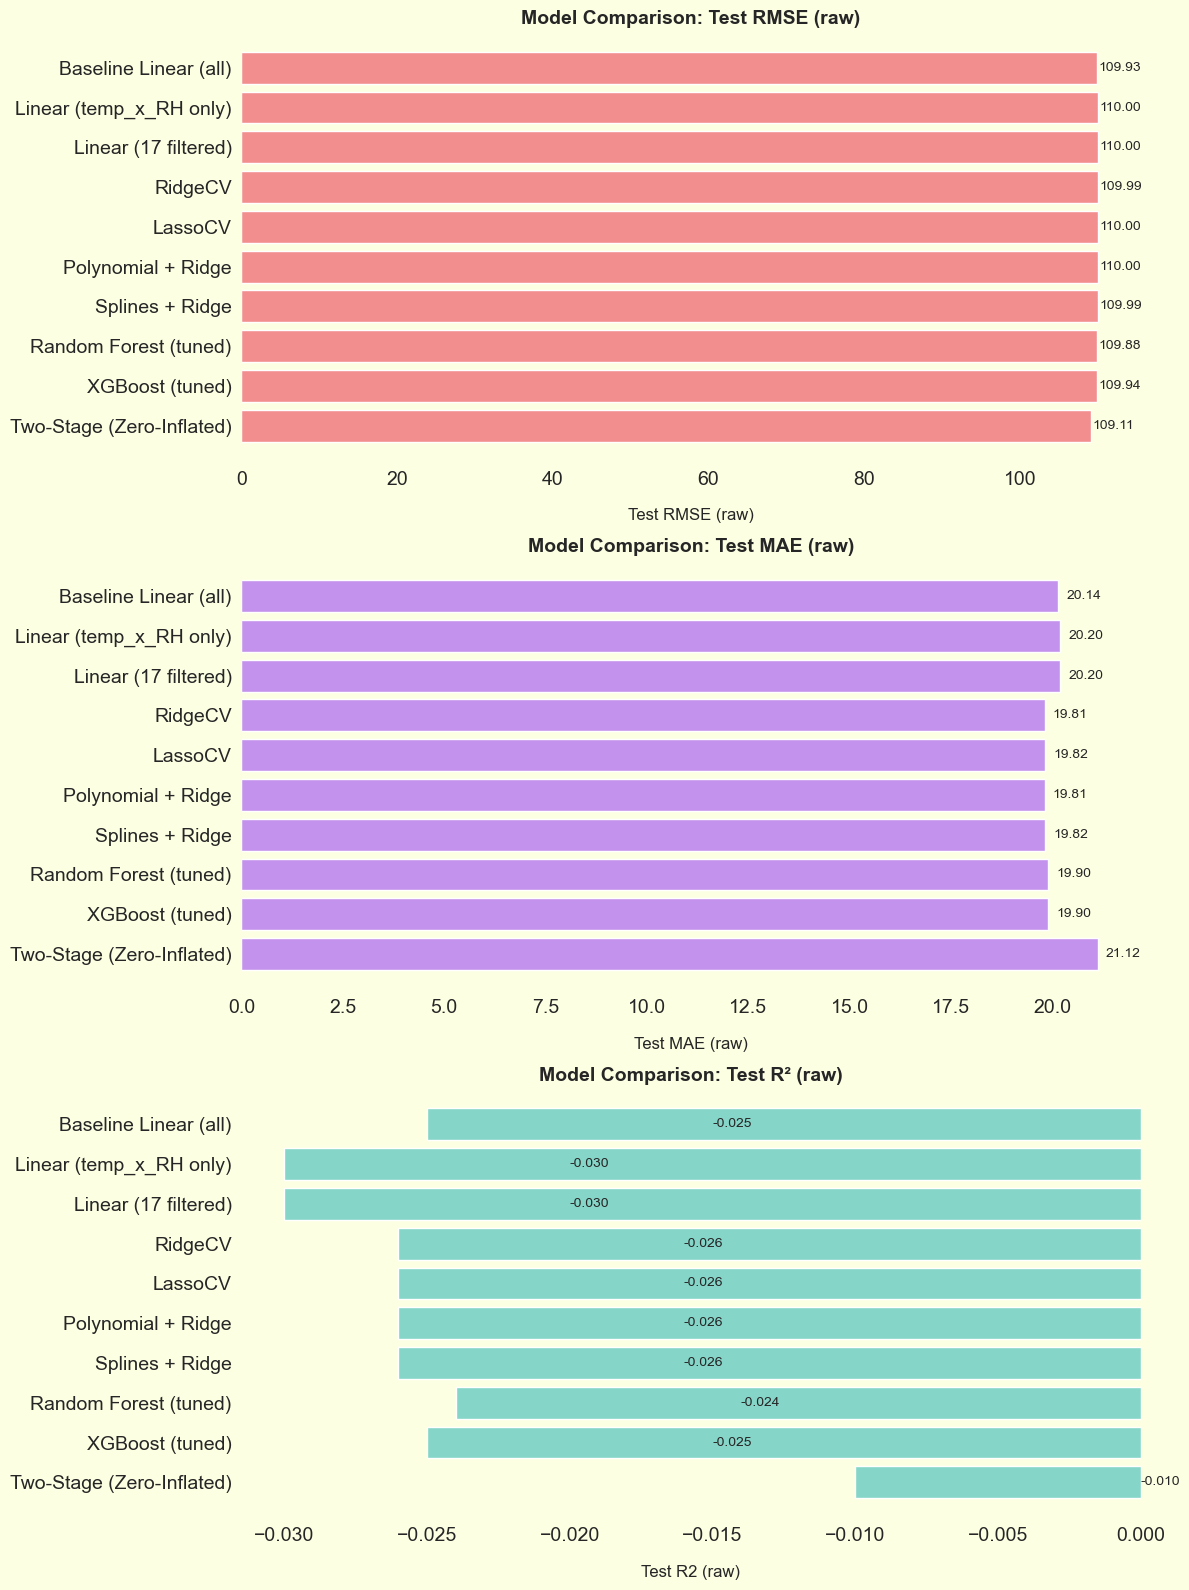

In [30]:
# Data from the comparison table
data = {
    "Model": [
        "Baseline Linear (all)",
        "Linear (temp_x_RH only)",
        "Linear (17 filtered)",
        "RidgeCV",
        "LassoCV",
        "Polynomial + Ridge",
        "Splines + Ridge",
        "Random Forest (tuned)",
        "XGBoost (tuned)",
        "Two-Stage (Zero-Inflated)",
    ],
    "Test RMSE (raw)": [
        109.93, 110.0, 110.0, 109.99, 110.0, 110.0, 109.99, 109.88, 109.94, 109.11
    ],
    "Test MAE (raw)": [
        20.14, 20.2, 20.2, 19.81, 19.82, 19.81, 19.82, 19.90, 19.90, 21.12
    ],
    "Test R2 (raw)": [
        -0.025, -0.03, -0.03, -0.026, -0.026, -0.026, -0.026, -0.024, -0.025, -0.010
    ],
}

df_results = pd.DataFrame(data)

# Create a single figure with 3 subplots (one per metric)
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# --- Subplot 1: RMSE ---
bars = axes[0].barh(df_results["Model"], df_results["Test RMSE (raw)"], color="#f28e8e")
axes[0].set_xlabel("Test RMSE (raw)", fontsize=12)
axes[0].set_title("Model Comparison: Test RMSE (raw)", fontsize=14, weight="bold")
axes[0].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axes[0].text(width + 0.2, bar.get_y() + bar.get_height()/2,
                 f"{width:.2f}", va="center", fontsize=10)

# --- Subplot 2: MAE ---
bars = axes[1].barh(df_results["Model"], df_results["Test MAE (raw)"], color="#c392ec")
axes[1].set_xlabel("Test MAE (raw)", fontsize=12)
axes[1].set_title("Model Comparison: Test MAE (raw)", fontsize=14, weight="bold")
axes[1].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axes[1].text(width + 0.2, bar.get_y() + bar.get_height()/2,
                 f"{width:.2f}", va="center", fontsize=10)

# --- Subplot 3: R² ---
bars = axes[2].barh(df_results["Model"], df_results["Test R2 (raw)"], color="#85d5c8")
axes[2].set_xlabel("Test R2 (raw)", fontsize=12)
axes[2].set_title("Model Comparison: Test R² (raw)", fontsize=14, weight="bold")
axes[2].invert_yaxis()
for bar in bars:
    width = bar.get_width()
    axes[2].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{width:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

| Model                        | CV RMSE (log)       | Test RMSE (log) | Test MAE (log) | Test R² (log) | Test RMSE (raw) | Test MAE (raw) | Test R² (raw) |
|------------------------------|---------------------|-----------------|----------------|---------------|-----------------|----------------|---------------|
| **Baseline Linear (all)**    | 1.426 ± 0.060       | 1.543           | 1.259          | -0.084        | 109.93          | 20.14          | -0.025        |
| **Linear (temp_x_RH only)**  | ~1.47               | ~1.55           | ~1.26          | ~-0.10        | ~110            | ~20.2          | ~-0.03        |
| **Linear (17 filtered)**     | ~1.44               | ~1.54           | ~1.26          | ~-0.09        | ~110            | ~20.2          | ~-0.03        |
| **RidgeCV**                  | 1.429 ± 0.033       | 1.482           | 1.201          | 0.001         | 109.99          | 19.81          | -0.026        |
| **LassoCV**                  | 1.385 ± 0.110       | 1.483           | 1.203          | -0.001        | 110.00          | 19.82          | -0.026        |
| **Polynomial + Ridge (deg=2)** | 1.947 ± 1.047     | 1.481           | 1.201          | 0.002         | 110.00          | 19.81          | -0.026        |
| **Splines + Ridge**          | 1.439 ± 0.046       | 1.483           | 1.202          | -0.001        | 109.99          | 19.82          | -0.026        |
| **Random Forest (tuned)**    | 1.387 ± 0.111       | 1.488           | 1.220          | -0.007        | 109.88          | 19.90          | -0.024        |
| **XGBoost (tuned)**          | 1.404 ± 0.115       | 1.499           | 1.217          | -0.022        | 109.94          | 19.90          | -0.025        |
| **Two-Stage (Zero-Inflated)**| ~1.36 (reg stage)   | 1.488           | 1.220          | -0.007        | **109.11**      | 21.12          | -0.010        |

---

### Key Observations
- **All models perform similarly**, with Test RMSE (raw) ≈ **109–110** and Test R² ≈ **~0.0 (slightly negative)**.  
- **Ridge, Lasso, Polynomial, Splines** → none significantly outperform plain Linear Regression.  
- **Random Forest and XGBoost** didn’t improve test performance either, though RF had the best CV RMSE.  
- **Two-Stage Model** gives a *slightly lower RMSE (raw)* than others (109.11 vs ~109.9), but at the cost of higher MAE.  
- Overall, **no method finds strong predictive signal** in the features → the dataset itself is highly challenging.  

✅ This table shows very clearly that the **dataset’s weak correlations with `area` are the limiting factor**, not model choice.  
